In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!pip install imbalanced-learn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import gc
# from keras.applications import DenseNet121
from tensorflow.keras.models import Model
# from tensorflow.keras import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Lambda, BatchNormalization
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
import os
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer

import logging
import pickle

import imblearn

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [ ]:
BASE_PATH = "/content/gdrive/MyDrive/KaggleDataBTP/gaussian_filtered_images/Pipeline_Model_testing/Model_2/"

In [ ]:
# logging.basicConfig(filename = "cro.log", level=logging.DEBUG, filemode='w+', format='%(name)s - %(levelname)s - %(message)s')

In [ ]:
def buildfinetunemodel():
    input = tf.keras.Input(shape=1024)
    x = tf.keras.layers.Activation(activation='relu')(input)
    x = tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.Dense(1024,activation='relu')(x)
    x= tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.Dense(1024)(x)
    output=tf.keras.layers.Dense(3,activation='softmax')(x)
    finetune_model = tf.keras.Model(input, output)
    finetune_model.compile(loss='binary_crossentropy',
                metrics=['accuracy'])


    return finetune_model

In [ ]:
finetune_model = buildfinetunemodel()
finetune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 3)                 3075  

In [ ]:
def change_label(x):
    if x == 1:
        return 0
    elif x == 2:
        return 1
    elif x == 3:
        return 2

In [ ]:
data_x = np.load(BASE_PATH + "data_x.npy")
data_y = np.load(BASE_PATH + "data_y.npy")

In [ ]:
data_x_model2 = []
data_y_model2 = []
for (dx, dy) in zip(data_x, data_y):
    if dy != 0:
        data_x_model2.append(dx)
        data_y_model2.append(change_label(dy))

In [ ]:
data_x_model2 = np.array(data_x_model2)
data_y_model2 = np.array(data_y_model2)

In [ ]:
np.unique(data_y_model2, return_counts = True)

(array([0, 1, 2]), array([370, 999, 295]))

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
data_x_model_2_overSampled, data_y_model_2_overSampled = oversample.fit_resample(data_x_model2, data_y_model2)

In [ ]:
np.unique(data_y_model_2_overSampled, return_counts = True)

(array([0, 1, 2]), array([999, 999, 999]))

- 0 -> Mild
- 1 -> Moderate
- 2 -> Severe

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(data_x_model_2_overSampled, data_y_model_2_overSampled, test_size = 0.15)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(np.unique(train_y, return_counts=True))
print(np.unique(test_y, return_counts=True))


(2547, 1024)
(2547,)
(450, 1024)
(450,)
(array([0, 1, 2]), array([854, 832, 861]))
(array([0, 1, 2]), array([145, 167, 138]))


In [ ]:
import random
import copy
import sys
import os
import sys
from tqdm import tqdm
import heapq

initializer = tf.keras.initializers.HeNormal()
vars = finetune_model.trainable_variables
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
acc_fn = tf.keras.metrics.Accuracy()

num_molecule = 20
mole_coll = 0.3
KE_loss_rate = 0.1
buffer = 400

In [ ]:
class Molecule:
    def __init__(self, vars = None, weights = None, velocity = None, ke = None, num_hit = None, local_best = None):
        if weights:
            self.weights = weights
        elif vars:
            self.weights = [initializer(shape=s.shape) for s in vars]
        self.PE, self.acc = self.get_loss()

        if ke:
            self.KE = ke
        else:
            self.KE = 1

        self.TE = self.PE + self.KE
        self.val_loss, self.val_acc = self.get_loss_val()

        if velocity:
            self.velocity = velocity
        else:
            self.velocity = [tf.random.normal(shape=s.shape, stddev = 0.1) for s in vars] #, minval = -1, maxval=1

        self.num_hit = 0 # How many time the perticular molecule exploited its search space.

        self.local_best = self.weights

        self.gradient_average = [tf.zeros(shape=s.shape) for s in vars]

    def update_best(self):
        if self.PE < self.get_loss_weight(self.local_best)[0]:
            self.local_best = self.weights

    def update_PE(self):
        self.PE, self.acc = self.get_loss()
        self.val_loss, self.val_acc = self.get_loss_val()

    def get_loss_weight(self, weight):
        finetune_model.set_weights(weights=weight)
        logits = finetune_model(train_x)
        # logits = tf.reshape(logits, (logits.shape[0], ))
        loss_value = loss_fn(train_y, logits)
        acc_value = accuracy_score(train_y, np.argmax(logits, axis=1))
        return loss_value, acc_value

    def get_loss(self):
        finetune_model.set_weights(weights=self.weights)
        logits = finetune_model(train_x)
        # logits = tf.reshape(logits, (logits.shape[0], ))
        loss_value = loss_fn(train_y, logits)
        acc_value = accuracy_score(train_y, np.argmax(logits, axis=1))
        return loss_value, acc_value

    def get_loss_val(self):
        finetune_model.set_weights(weights=self.weights)
        logits = finetune_model(test_x)
        # logits = tf.reshape(logits, (logits.shape[0], ))
        loss_value = loss_fn(test_y, logits)
        acc_value = accuracy_score(test_y, np.argmax(logits, axis=1))
        return loss_value, acc_value

    def reset_average(self):
        self.gradient_average = [tf.zeros(shape=s.shape) for s in vars]

In [ ]:
def create_molecule():
    m = Molecule(vars)
    m.velocity = [(global_best[i]- m.weights[i]) for i in range(len(global_best))]
    return m

def pso_update(m):
    r1 = random.random()
    r2 = random.random()
    first_term = [w*l_v for l_v in m.velocity]
    second_term = [c1*r1*x for x in [(m.local_best[i]- m.weights[i]) for i in range(len(m.local_best))]]
    third_term = [c2*r2*x for x in [(global_best[i]- m.weights[i]) for i in range(len(global_best))]]
    m.velocity = [m.KE * (first_term[i] + second_term[i] + third_term[i]) for i in range(len(first_term))]

    m.weights = [(m.weights[i]+ m.velocity[i]) for i in range(len(m.weights))]
    m.update_PE()
    m.num_hit = 0
    m.update_best()
    m.reset_average()
    if m.PE > 10:
        m = create_molecule()
    del first_term
    del second_term
    del third_term
    gc.collect()
    return m

def neighbourhood(m, learning_rate, momentum):

    with tf.GradientTape(watch_accessed_variables=False) as t:
        t.reset()
        t.watch(finetune_model.trainable_variables)
        finetune_model.set_weights(weights=m.weights)
        logits = finetune_model(train_x)
        # logits = tf.reshape(logits, (logits.shape[0], ))
        loss_value = loss_fn(train_y, logits)

    gradients = t.gradient(loss_value, finetune_model.trainable_weights)

    for i in range(len(finetune_model.trainable_weights)):
        m.gradient_average[i] = momentum * m.gradient_average[i] + (1-momentum) * gradients[i]



    new_weights = []
    for i in range(len(finetune_model.trainable_weights)):
        layer = finetune_model.trainable_weights[i]
        layer =  layer - learning_rate * m.gradient_average[i]
        new_weights.append(layer)

    m.weights = new_weights
    m.update_PE()
    if m.PE > 10:
        m = create_molecule()
    del gradients
    del new_weights
    gc.collect()
    return m

def onwall_ineffective_collision(m):
    return neighbourhood(m, learning_rate, momemtum)

def onwall_criteria(m_old, m_new):
    pe_new = m_new.PE
    if (m_old.PE + m_old.KE >= pe_new):
        return True
    else:
        return False

def intermol_criteria(m1, m2, m1_new, m2_new):
    pe1 = m1_new.PE
    pe2 = m2_new.PE
    if (m1.PE + m1.KE + m2.PE + m2.KE >= pe1 + pe2):
        return True
    else:
        return False

def intermol_ineffective_collision(m1, m2):
    return (neighbourhood(m1, learning_rate, momemtum), neighbourhood(m2, learning_rate, momemtum)) #instead of creating new

def best_molecule():
    bm = molecule[0]
    for m in molecule:
        if m.PE < bm.PE:
            bm = m
    return bm


def execute_intermol_ineffective_collision(m1, m2, i, j):
    global buffer
    m1_copy = copy.deepcopy(m1)
    m2_copy = copy.deepcopy(m2)
    (m1_new, m2_new) = intermol_ineffective_collision(m1, m2)
    if(intermol_criteria(m1_copy, m2_copy, m1_new, m2_new)):
        pe_x1 = m1_copy.PE
        pe_x2 = m2_copy.PE
        ke_x1 = m1_copy.KE
        ke_x2 = m2_copy.KE
        p = random.random()
        m1_new.KE = (pe_x1 + pe_x2 + ke_x1 + ke_x2 - m1_new.PE - m2_new.PE) * p
        m2_new.KE = (pe_x1 + pe_x2 + ke_x1 + ke_x2 - m1_new.PE - m2_new.PE) * (1-p)

        m1_new.num_hit += 1
        m2_new.num_hit += 1

        m1_new.update_best()
        m2_new.update_best()

        if tf.math.is_nan(m1_new.PE) or tf.math.is_nan(m2_new.PE):
            print("NaN Occured Here")
            sys.exit()
        # molecule.append(m1_new)
        # molecule.append(m2_new)

        molecule[i] = m1_new
        molecule[j] = m2_new

        logging.info(f"Current PE : {m1_new.PE} , {m2_new.PE}")
        return True
    else:
        return False

def execute_onwall_collision(m_old, i):
    global buffer
    m_old_copy = copy.deepcopy(m_old)
    m_new = onwall_ineffective_collision(m_old)
    if onwall_criteria(m_old_copy, m_new):
        p1 = random.uniform(KE_loss_rate, 1)
        pe_new = m_new.PE
        ke_new = m_new.KE = (m_old_copy.PE - pe_new + m_old_copy.KE) * p1
        buffer = buffer + ((m_old_copy.PE - pe_new + m_old_copy.KE)*(1-p1))
        m_new.num_hit += 1
        m_new.update_best()
        if tf.math.is_nan(m_new.PE):
            print("NaN Occured Here")
            os._exit(0)


        # molecule.append(m_new)
        molecule[i] = m_new
        logging.info(f"Current PE : {m_new.PE}")
        return True
    else:
        return False

def execute_pso_upadte(m_old, i):
    global buffer
    m_new = pso_update(m_old)
    if tf.math.is_nan(m_new.PE):
        print("NaN Occured Here")
        os._exit(0)
    molecule[i] = m_new
    logging.info(f"Current PE : {m_new.PE}")



def save_molecules(molecules, file_name1 = "molecule_weights"):
    file_name = BASE_PATH + file_name1
    molecule_to_save = []
    for m in molecule:
        molecule_to_save.append([m.weights, m.velocity, m.num_hit, m.KE, m.local_best])
    with open(file_name, "wb") as fp:
        pickle.dump(molecule_to_save, fp)

def read_molecule(file_name1 = "molecule_weights"):
    file_name = BASE_PATH + file_name1
    with open(file_name, "rb") as fp:
        molecules_meta_data = pickle.load(fp)
    molecules = []
    for m_data in molecules_meta_data:
        molecules.append(Molecule(vars = vars, weights=m_data[0], velocity=m_data[1], num_hit = m_data[2], ke = m_data[3], local_best= m_data[4]))
    return molecules

In [ ]:
molecule = read_molecule("model2_cro_molecule_weights_20_500")

In [ ]:
bm = best_molecule()

In [ ]:
file_name = BASE_PATH + "model2_bm_weights"
with open(file_name, "wb") as fp:
    pickle.dump(bm.weights, fp)

In [ ]:
molecule = []
for i in tqdm(range(num_molecule)):
    m = Molecule(vars)
    # m_new = neighbourhood(m, 0.01)
    molecule.append(m)

100%|██████████| 20/20 [00:03<00:00,  6.36it/s]


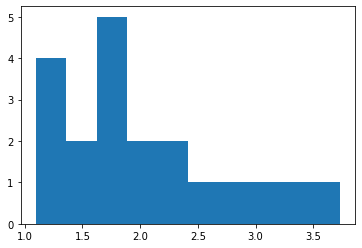

In [ ]:
allPE = []
for m in molecule:
    allPE.append(m.PE)

import matplotlib.pyplot as plt
plt.hist(allPE)
plt.show()

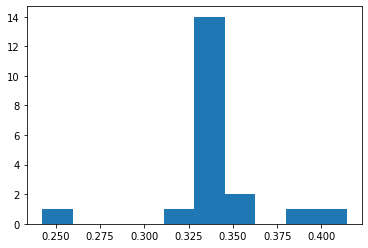

In [ ]:
allAcc = []
for m in molecule:
    allAcc.append(m.acc)

import matplotlib.pyplot as plt
plt.hist(allAcc)
plt.show()

In [ ]:
molecule_pe_before = []
for m in molecule:
    molecule_pe_before.append(m.PE)

molecule_acc_before = []
for m in molecule:
    molecule_acc_before.append(m.acc)


In [ ]:
print(f"\nMinimum PE {best_molecule().PE, best_molecule().acc}")

y = 40
w = float(0.6)
c1 = float(0.1)
c2 = float(0.9)
learning_rate = 0.005
momemtum = 0.5
global_best = best_molecule().weights


Minimum PE (<tf.Tensor: shape=(), dtype=float32, numpy=1.0954696>, 0.41421279937181)


In [ ]:
loss_history = []
val_loss_history = []
acc_history = []
val_acc_history = []

loss_history_epochs = []
val_loss_history_epochs = []
acc_history_epochs = []
val_acc_history_epochs = []

In [ ]:
num_epochs = 500
e = 0
while(1):
    print(f"Epochs : {e+1}")
    for idx in tqdm(range(len(molecule))):
        # idx = random.randint(0, len(molecule)-1)
        m = molecule[idx]
        # molecule.pop(idx)
        if m.num_hit > y:
            execute_pso_upadte(m, idx)
            logging.info(f"Epochs : {e+1}\tPSO Update ")
        else:
            r = random.random()
            if r > 0.5:
                i = random.randint(0, len(molecule)-1)
                m1 = molecule[i]
                # molecule.pop(i)
                if execute_intermol_ineffective_collision(m, m1, idx, i):
                    logging.info(f"Epochs : {e+1}\tInter Mole ")
                else:
                    logging.info(f"Epochs : {e+1}\tNone ")
                    molecule[idx].num_hit += 1
                    molecule[i].num_hit += 1
                    # molecule.append(m)
                    # molecule.append(m1)
            else:
                if execute_onwall_collision(m, idx):
                    logging.info(f"Epochs : {e+1}\tOn wall ")
                else:
                    logging.info(f"Epochs : {e+1}\tNone ")
                    molecule[idx].num_hit += 1
                    # molecule.append(m)

        global_best_mole = best_molecule()
        global_best = global_best_mole.weights
        loss_history.append(global_best_mole.PE)
        val_loss_history.append(global_best_mole.val_loss)
        acc_history.append(global_best_mole.acc)
        val_acc_history.append(global_best_mole.val_acc)


    print(f"Loss : {global_best_mole.PE}, Val Loss : {global_best_mole.val_loss} Acc : {global_best_mole.acc}, Val Acc : {global_best_mole.val_acc}")
    loss_history_epochs.append(global_best_mole.PE)
    val_loss_history_epochs.append(global_best_mole.val_loss)
    acc_history_epochs.append(global_best_mole.acc)
    val_acc_history_epochs.append(global_best_mole.val_acc)

    e += 1
    if e == num_epochs:
        break

Epochs : 1


100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Loss : 1.0699429512023926, Val Loss : 1.0955907106399536 Acc : 0.41460541813898705, Val Acc : 0.4
Epochs : 2


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 1.0669363737106323, Val Loss : 1.090558648109436 Acc : 0.4326658814291323, Val Acc : 0.4111111111111111
Epochs : 3


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 1.0469605922698975, Val Loss : 1.077964186668396 Acc : 0.44405182567726736, Val Acc : 0.42444444444444446
Epochs : 4


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 1.040270209312439, Val Loss : 1.0708168745040894 Acc : 0.4558303886925795, Val Acc : 0.42444444444444446
Epochs : 5


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Loss : 1.025660753250122, Val Loss : 1.0611149072647095 Acc : 0.4683941892422458, Val Acc : 0.43777777777777777
Epochs : 6


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 1.019283413887024, Val Loss : 1.0551973581314087 Acc : 0.4801727522575579, Val Acc : 0.4444444444444444
Epochs : 7


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 1.007206678390503, Val Loss : 1.0465182065963745 Acc : 0.4876325088339223, Val Acc : 0.4577777777777778
Epochs : 8


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.9962546825408936, Val Loss : 1.0379246473312378 Acc : 0.49980369061641144, Val Acc : 0.46
Epochs : 9


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.9911269545555115, Val Loss : 1.0340696573257446 Acc : 0.5056929721240675, Val Acc : 0.4666666666666667
Epochs : 10


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Loss : 0.9814851880073547, Val Loss : 1.0266424417495728 Acc : 0.5080486847271299, Val Acc : 0.46444444444444444
Epochs : 11


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.9690218567848206, Val Loss : 1.0075929164886475 Acc : 0.5465253239104829, Val Acc : 0.4888888888888889
Epochs : 12


100%|██████████| 20/20 [00:04<00:00,  4.00it/s]


Loss : 0.9646286368370056, Val Loss : 1.0040135383605957 Acc : 0.552414605418139, Val Acc : 0.4955555555555556
Epochs : 13


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.9523892402648926, Val Loss : 0.9938919544219971 Acc : 0.5630153121319199, Val Acc : 0.5088888888888888
Epochs : 14


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Loss : 0.9485999941825867, Val Loss : 0.9907512664794922 Acc : 0.5641931684334511, Val Acc : 0.5066666666666667
Epochs : 15


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.9414065480232239, Val Loss : 0.9849075078964233 Acc : 0.5720455437769926, Val Acc : 0.5133333333333333
Epochs : 16


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Loss : 0.9379895329475403, Val Loss : 0.9821186661720276 Acc : 0.574401256380055, Val Acc : 0.5088888888888888
Epochs : 17


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.9314818978309631, Val Loss : 0.9768797755241394 Acc : 0.5791126815861798, Val Acc : 0.52
Epochs : 18


100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


Loss : 0.9253817200660706, Val Loss : 0.9720039963722229 Acc : 0.5865724381625441, Val Acc : 0.5222222222222223
Epochs : 19


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.9196323752403259, Val Loss : 0.967418909072876 Acc : 0.5904986258343149, Val Acc : 0.5155555555555555
Epochs : 20


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.9168710112571716, Val Loss : 0.9652259945869446 Acc : 0.5924617196702002, Val Acc : 0.5177777777777778
Epochs : 21


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.9141766428947449, Val Loss : 0.96307772397995 Acc : 0.5956026698076168, Val Acc : 0.52
Epochs : 22


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Loss : 0.9089899063110352, Val Loss : 0.958932638168335 Acc : 0.5995288574793876, Val Acc : 0.5311111111111111
Epochs : 23


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.9040706753730774, Val Loss : 0.9549822807312012 Acc : 0.6003140950137417, Val Acc : 0.5355555555555556
Epochs : 24


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.8993991017341614, Val Loss : 0.9512364864349365 Acc : 0.6046329014526894, Val Acc : 0.54
Epochs : 25


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Loss : 0.8990163803100586, Val Loss : 0.949840247631073 Acc : 0.6050255202198666, Val Acc : 0.5511111111111111
Epochs : 26


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.8938949704170227, Val Loss : 0.9464529156684875 Acc : 0.6093443266588143, Val Acc : 0.5466666666666666
Epochs : 27


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.8877575397491455, Val Loss : 0.9419408440589905 Acc : 0.6117000392618768, Val Acc : 0.54
Epochs : 28


100%|██████████| 20/20 [00:05<00:00,  4.00it/s]


Loss : 0.8857622146606445, Val Loss : 0.9407886266708374 Acc : 0.6109148017275225, Val Acc : 0.54
Epochs : 29


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


Loss : 0.8838095664978027, Val Loss : 0.9390843510627747 Acc : 0.613270514330585, Val Acc : 0.5377777777777778
Epochs : 30


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.8819142580032349, Val Loss : 0.9374691843986511 Acc : 0.6144483706321162, Val Acc : 0.54
Epochs : 31


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.8800573348999023, Val Loss : 0.9361606240272522 Acc : 0.6136631330977621, Val Acc : 0.54
Epochs : 32


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.8764737844467163, Val Loss : 0.9332539439201355 Acc : 0.6183745583038869, Val Acc : 0.5422222222222223
Epochs : 33


100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


Loss : 0.8747392892837524, Val Loss : 0.9319466352462769 Acc : 0.6199450333725952, Val Acc : 0.5444444444444444
Epochs : 34


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.8730382323265076, Val Loss : 0.9306116104125977 Acc : 0.6207302709069493, Val Acc : 0.5422222222222223
Epochs : 35


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.8713711500167847, Val Loss : 0.929279088973999 Acc : 0.6223007459756577, Val Acc : 0.5422222222222223
Epochs : 36


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Loss : 0.8697407841682434, Val Loss : 0.9280154705047607 Acc : 0.6230859835100118, Val Acc : 0.5422222222222223
Epochs : 37


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.8677276372909546, Val Loss : 0.9081145524978638 Acc : 0.6380054966627405, Val Acc : 0.5888888888888889
Epochs : 38


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.8624523282051086, Val Loss : 0.9041633009910583 Acc : 0.64075382803298, Val Acc : 0.5933333333333334
Epochs : 39


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.860763430595398, Val Loss : 0.9029063582420349 Acc : 0.6403612092658029, Val Acc : 0.5955555555555555
Epochs : 40


100%|██████████| 20/20 [00:05<00:00,  3.84it/s]


Loss : 0.8591085076332092, Val Loss : 0.9016850590705872 Acc : 0.6403612092658029, Val Acc : 0.5955555555555555
Epochs : 41


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.8574842810630798, Val Loss : 0.9004941582679749 Acc : 0.6399685904986259, Val Acc : 0.5911111111111111
Epochs : 42


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.8512831926345825, Val Loss : 0.8959466814994812 Acc : 0.6387907341970946, Val Acc : 0.5977777777777777
Epochs : 43


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.848341703414917, Val Loss : 0.8937709331512451 Acc : 0.6395759717314488, Val Acc : 0.6
Epochs : 44


100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


Loss : 0.846905529499054, Val Loss : 0.8927051424980164 Acc : 0.6399685904986259, Val Acc : 0.6
Epochs : 45


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.8454933762550354, Val Loss : 0.8916537165641785 Acc : 0.6403612092658029, Val Acc : 0.6
Epochs : 46


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.8427463173866272, Val Loss : 0.889614462852478 Acc : 0.6415390655673341, Val Acc : 0.6022222222222222
Epochs : 47


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.8387937545776367, Val Loss : 0.8867043256759644 Acc : 0.6454652532391049, Val Acc : 0.6022222222222222
Epochs : 48


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.8362599611282349, Val Loss : 0.8848356604576111 Acc : 0.646250490773459, Val Acc : 0.6044444444444445
Epochs : 49


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.835017204284668, Val Loss : 0.8839266896247864 Acc : 0.6466431095406361, Val Acc : 0.6044444444444445
Epochs : 50


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.8313845992088318, Val Loss : 0.8812640309333801 Acc : 0.6478209658421673, Val Acc : 0.6066666666666667
Epochs : 51


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Loss : 0.830206573009491, Val Loss : 0.8803941607475281 Acc : 0.6474283470749902, Val Acc : 0.6066666666666667
Epochs : 52


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.8290424942970276, Val Loss : 0.8795351982116699 Acc : 0.6478209658421673, Val Acc : 0.6111111111111112
Epochs : 53


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


Loss : 0.827892005443573, Val Loss : 0.8786868453025818 Acc : 0.6478209658421673, Val Acc : 0.6111111111111112
Epochs : 54


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.8256268501281738, Val Loss : 0.8770056962966919 Acc : 0.6497840596780526, Val Acc : 0.6133333333333333
Epochs : 55


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.8245141506195068, Val Loss : 0.876183271408081 Acc : 0.6501766784452296, Val Acc : 0.6133333333333333
Epochs : 56


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.8239671587944031, Val Loss : 0.8757771849632263 Acc : 0.6501766784452296, Val Acc : 0.6133333333333333
Epochs : 57


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


Loss : 0.8231515288352966, Val Loss : 0.8751791715621948 Acc : 0.6505692972124067, Val Acc : 0.6155555555555555
Epochs : 58


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Loss : 0.8222074508666992, Val Loss : 0.8744853138923645 Acc : 0.6513545347467609, Val Acc : 0.6155555555555555
Epochs : 59


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.8212053775787354, Val Loss : 0.873751699924469 Acc : 0.6521397722811151, Val Acc : 0.6155555555555555
Epochs : 60


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.8201810121536255, Val Loss : 0.8729991316795349 Acc : 0.6537102473498233, Val Acc : 0.6177777777777778
Epochs : 61


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.8191545605659485, Val Loss : 0.8722405433654785 Acc : 0.6552807224185316, Val Acc : 0.6177777777777778
Epochs : 62


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.8181319832801819, Val Loss : 0.871487557888031 Acc : 0.6552807224185316, Val Acc : 0.6177777777777778
Epochs : 63


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.8171176910400391, Val Loss : 0.870746910572052 Acc : 0.6560659599528857, Val Acc : 0.6177777777777778
Epochs : 64


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.8161137700080872, Val Loss : 0.8700166940689087 Acc : 0.6576364350215941, Val Acc : 0.6177777777777778
Epochs : 65


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.8122066855430603, Val Loss : 0.8671757578849792 Acc : 0.6611700039261876, Val Acc : 0.6155555555555555
Epochs : 66


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.8103145360946655, Val Loss : 0.8658030033111572 Acc : 0.6611700039261876, Val Acc : 0.6177777777777778
Epochs : 67


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.8084588050842285, Val Loss : 0.8644547462463379 Acc : 0.662740478994896, Val Acc : 0.6177777777777778
Epochs : 68


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.8075423240661621, Val Loss : 0.8637862205505371 Acc : 0.6623478602277189, Val Acc : 0.62
Epochs : 69


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.8048363327980042, Val Loss : 0.8618168234825134 Acc : 0.6631330977620731, Val Acc : 0.6177777777777778
Epochs : 70


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.8022119402885437, Val Loss : 0.8598946332931519 Acc : 0.6631330977620731, Val Acc : 0.6177777777777778
Epochs : 71


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Loss : 0.8013522624969482, Val Loss : 0.8592670559883118 Acc : 0.6635257165292501, Val Acc : 0.6177777777777778
Epochs : 72


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.8004989624023438, Val Loss : 0.8586427569389343 Acc : 0.662740478994896, Val Acc : 0.6111111111111112
Epochs : 73


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.7996525764465332, Val Loss : 0.8580243587493896 Acc : 0.662740478994896, Val Acc : 0.6111111111111112
Epochs : 74


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.7979798316955566, Val Loss : 0.8567924499511719 Acc : 0.6635257165292501, Val Acc : 0.6111111111111112
Epochs : 75


100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


Loss : 0.7971533536911011, Val Loss : 0.8561793565750122 Acc : 0.6643109540636042, Val Acc : 0.6133333333333333
Epochs : 76


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.7955207824707031, Val Loss : 0.8549751043319702 Acc : 0.6647035728307813, Val Acc : 0.6111111111111112
Epochs : 77


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.7947143316268921, Val Loss : 0.8543773889541626 Acc : 0.6654888103651354, Val Acc : 0.6111111111111112
Epochs : 78


100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


Loss : 0.7939139604568481, Val Loss : 0.8537870049476624 Acc : 0.6670592854338437, Val Acc : 0.6111111111111112
Epochs : 79


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.7931214570999146, Val Loss : 0.853193998336792 Acc : 0.668237141735375, Val Acc : 0.6111111111111112
Epochs : 80


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loss : 0.7923380136489868, Val Loss : 0.8526094555854797 Acc : 0.6678445229681979, Val Acc : 0.6111111111111112
Epochs : 81


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.7907941341400146, Val Loss : 0.851451575756073 Acc : 0.6694149980369062, Val Acc : 0.6111111111111112
Epochs : 82


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.7900308966636658, Val Loss : 0.8508784174919128 Acc : 0.6702002355712603, Val Acc : 0.6111111111111112
Epochs : 83


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.789273202419281, Val Loss : 0.8503178358078003 Acc : 0.6702002355712603, Val Acc : 0.6111111111111112
Epochs : 84


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.7885211706161499, Val Loss : 0.8497567176818848 Acc : 0.6698076168040832, Val Acc : 0.6111111111111112
Epochs : 85


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.7885211706161499, Val Loss : 0.8497567176818848 Acc : 0.6698076168040832, Val Acc : 0.6111111111111112
Epochs : 86


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Loss : 0.788148820400238, Val Loss : 0.8494783639907837 Acc : 0.6694149980369062, Val Acc : 0.6111111111111112
Epochs : 87


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.7875919938087463, Val Loss : 0.8490606546401978 Acc : 0.6702002355712603, Val Acc : 0.6111111111111112
Epochs : 88


100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


Loss : 0.7862540483474731, Val Loss : 0.8480662107467651 Acc : 0.6702002355712603, Val Acc : 0.6111111111111112
Epochs : 89


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.7848339080810547, Val Loss : 0.8470061421394348 Acc : 0.6702002355712603, Val Acc : 0.6111111111111112
Epochs : 90


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.7834123969078064, Val Loss : 0.8459436893463135 Acc : 0.6705928543384374, Val Acc : 0.6111111111111112
Epochs : 91


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.7820035815238953, Val Loss : 0.8448969125747681 Acc : 0.6705928543384374, Val Acc : 0.6155555555555555
Epochs : 92


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.7813045382499695, Val Loss : 0.8443804979324341 Acc : 0.6705928543384374, Val Acc : 0.6111111111111112
Epochs : 93


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.7799168825149536, Val Loss : 0.8433572053909302 Acc : 0.6713780918727915, Val Acc : 0.6111111111111112
Epochs : 94


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.7778749465942383, Val Loss : 0.8418592214584351 Acc : 0.6733411857086768, Val Acc : 0.6111111111111112
Epochs : 95


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.7758707404136658, Val Loss : 0.8403947353363037 Acc : 0.6749116607773852, Val Acc : 0.6111111111111112
Epochs : 96


100%|██████████| 20/20 [00:04<00:00,  4.05it/s]


Loss : 0.7752112150192261, Val Loss : 0.8399098515510559 Acc : 0.6756968983117393, Val Acc : 0.6111111111111112
Epochs : 97


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.774556577205658, Val Loss : 0.8394289612770081 Acc : 0.6756968983117393, Val Acc : 0.6111111111111112
Epochs : 98


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.7739077806472778, Val Loss : 0.8389506936073303 Acc : 0.6756968983117393, Val Acc : 0.6111111111111112
Epochs : 99


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.7732635736465454, Val Loss : 0.8384785056114197 Acc : 0.6753042795445622, Val Acc : 0.6111111111111112
Epochs : 100


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.7726238369941711, Val Loss : 0.8380052447319031 Acc : 0.6753042795445622, Val Acc : 0.6133333333333333
Epochs : 101


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.7719894051551819, Val Loss : 0.8375363349914551 Acc : 0.6753042795445622, Val Acc : 0.6133333333333333
Epochs : 102


100%|██████████| 20/20 [00:04<00:00,  4.05it/s]


Loss : 0.7713615298271179, Val Loss : 0.8370695114135742 Acc : 0.6756968983117393, Val Acc : 0.6133333333333333
Epochs : 103


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.7701187133789062, Val Loss : 0.8361431360244751 Acc : 0.6760895170789164, Val Acc : 0.6133333333333333
Epochs : 104


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.7695025205612183, Val Loss : 0.8356874585151672 Acc : 0.6764821358460934, Val Acc : 0.6133333333333333
Epochs : 105


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.7688899636268616, Val Loss : 0.8352407217025757 Acc : 0.6764821358460934, Val Acc : 0.6133333333333333
Epochs : 106


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.7670720815658569, Val Loss : 0.8338987231254578 Acc : 0.6772673733804476, Val Acc : 0.6111111111111112
Epochs : 107


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.7664718627929688, Val Loss : 0.8334589004516602 Acc : 0.6768747546132705, Val Acc : 0.6133333333333333
Epochs : 108


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.7658756375312805, Val Loss : 0.8330162763595581 Acc : 0.6780526109148017, Val Acc : 0.6133333333333333
Epochs : 109


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Loss : 0.7652814388275146, Val Loss : 0.8325726985931396 Acc : 0.6784452296819788, Val Acc : 0.6133333333333333
Epochs : 110


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.7641013860702515, Val Loss : 0.8317024111747742 Acc : 0.6804083235178642, Val Acc : 0.6133333333333333
Epochs : 111


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.7635170817375183, Val Loss : 0.8312662839889526 Acc : 0.6808009422850412, Val Acc : 0.6133333333333333
Epochs : 112


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Loss : 0.7629367709159851, Val Loss : 0.8308348655700684 Acc : 0.6808009422850412, Val Acc : 0.6133333333333333
Epochs : 113


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Loss : 0.7623600959777832, Val Loss : 0.8304091095924377 Acc : 0.6808009422850412, Val Acc : 0.6133333333333333
Epochs : 114


100%|██████████| 20/20 [00:04<00:00,  4.02it/s]


Loss : 0.7623600959777832, Val Loss : 0.8304091095924377 Acc : 0.6808009422850412, Val Acc : 0.6133333333333333
Epochs : 115


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.7611466646194458, Val Loss : 0.8295095562934875 Acc : 0.6811935610522183, Val Acc : 0.6133333333333333
Epochs : 116


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.7600682973861694, Val Loss : 0.828711211681366 Acc : 0.6823714173537495, Val Acc : 0.6155555555555555
Epochs : 117


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.7589578628540039, Val Loss : 0.8278887271881104 Acc : 0.6835492736552807, Val Acc : 0.6177777777777778
Epochs : 118


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Loss : 0.7584004402160645, Val Loss : 0.827480137348175 Acc : 0.6843345111896348, Val Acc : 0.6177777777777778
Epochs : 119


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.7578424215316772, Val Loss : 0.8270699977874756 Acc : 0.684727129956812, Val Acc : 0.6177777777777778
Epochs : 120


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.7561774849891663, Val Loss : 0.825866162776947 Acc : 0.6855123674911661, Val Acc : 0.62
Epochs : 121


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.7556278705596924, Val Loss : 0.8254688382148743 Acc : 0.6859049862583432, Val Acc : 0.6222222222222222
Epochs : 122


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.7550820708274841, Val Loss : 0.8250758647918701 Acc : 0.6859049862583432, Val Acc : 0.6222222222222222
Epochs : 123


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.753462553024292, Val Loss : 0.8239031434059143 Acc : 0.6874754613270514, Val Acc : 0.6244444444444445
Epochs : 124


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.7529279589653015, Val Loss : 0.8235191702842712 Acc : 0.6878680800942285, Val Acc : 0.6244444444444445
Epochs : 125


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.7518651485443115, Val Loss : 0.822754979133606 Acc : 0.6882606988614056, Val Acc : 0.6244444444444445
Epochs : 126


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.7513375282287598, Val Loss : 0.8223779201507568 Acc : 0.6886533176285826, Val Acc : 0.6222222222222222
Epochs : 127


100%|██████████| 20/20 [00:05<00:00,  3.95it/s]


Loss : 0.7497707009315491, Val Loss : 0.8212399482727051 Acc : 0.690223792697291, Val Acc : 0.6266666666666667
Epochs : 128


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.7477208375930786, Val Loss : 0.8197376132011414 Acc : 0.6914016489988222, Val Acc : 0.6266666666666667
Epochs : 129


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.7472164630889893, Val Loss : 0.8193672895431519 Acc : 0.6917942677659992, Val Acc : 0.6266666666666667
Epochs : 130


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.7457204461097717, Val Loss : 0.8182588815689087 Acc : 0.6933647428347075, Val Acc : 0.6266666666666667
Epochs : 131


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.7447367906570435, Val Loss : 0.8175206184387207 Acc : 0.6941499803690616, Val Acc : 0.6266666666666667
Epochs : 132


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.7437620759010315, Val Loss : 0.8167977333068848 Acc : 0.6953278366705928, Val Acc : 0.6244444444444445
Epochs : 133


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.7427991032600403, Val Loss : 0.8160716891288757 Acc : 0.69572045543777, Val Acc : 0.6244444444444445
Epochs : 134


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Loss : 0.7423202395439148, Val Loss : 0.8157111406326294 Acc : 0.69572045543777, Val Acc : 0.6244444444444445
Epochs : 135


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.7418420314788818, Val Loss : 0.8153494596481323 Acc : 0.69572045543777, Val Acc : 0.6244444444444445
Epochs : 136


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


Loss : 0.7413657307624817, Val Loss : 0.8149914145469666 Acc : 0.6965056929721241, Val Acc : 0.6244444444444445
Epochs : 137


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.7413657307624817, Val Loss : 0.8149914145469666 Acc : 0.6965056929721241, Val Acc : 0.6244444444444445
Epochs : 138


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.740364134311676, Val Loss : 0.8142381310462952 Acc : 0.6972909305064782, Val Acc : 0.6244444444444445
Epochs : 139


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.7394775152206421, Val Loss : 0.8135623335838318 Acc : 0.6984687868080094, Val Acc : 0.6222222222222222
Epochs : 140


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


Loss : 0.7390249967575073, Val Loss : 0.8132182359695435 Acc : 0.6988614055751865, Val Acc : 0.6222222222222222
Epochs : 141


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.7381187081336975, Val Loss : 0.8125255107879639 Acc : 0.6996466431095406, Val Acc : 0.6244444444444445
Epochs : 142


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.7376663684844971, Val Loss : 0.8121793866157532 Acc : 0.6988614055751865, Val Acc : 0.6244444444444445
Epochs : 143


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.7372161746025085, Val Loss : 0.8118324875831604 Acc : 0.6988614055751865, Val Acc : 0.6266666666666667
Epochs : 144


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.7363218665122986, Val Loss : 0.8111474514007568 Acc : 0.6996466431095406, Val Acc : 0.6266666666666667
Epochs : 145


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.7358769774436951, Val Loss : 0.8108097910881042 Acc : 0.6996466431095406, Val Acc : 0.6288888888888889
Epochs : 146


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.7354347109794617, Val Loss : 0.8104733228683472 Acc : 0.7000392618767177, Val Acc : 0.6288888888888889
Epochs : 147


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.7345566749572754, Val Loss : 0.8098010420799255 Acc : 0.7004318806438948, Val Acc : 0.6288888888888889
Epochs : 148


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.7336856126785278, Val Loss : 0.8091386556625366 Acc : 0.7008244994110718, Val Acc : 0.6311111111111111
Epochs : 149


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.7332521677017212, Val Loss : 0.8088099956512451 Acc : 0.7008244994110718, Val Acc : 0.6311111111111111
Epochs : 150


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


Loss : 0.7328195571899414, Val Loss : 0.8084790110588074 Acc : 0.7004318806438948, Val Acc : 0.6311111111111111
Epochs : 151


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.7323877215385437, Val Loss : 0.8081499338150024 Acc : 0.7004318806438948, Val Acc : 0.6333333333333333
Epochs : 152


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Loss : 0.731956422328949, Val Loss : 0.8078240156173706 Acc : 0.7004318806438948, Val Acc : 0.6311111111111111
Epochs : 153


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.7315264344215393, Val Loss : 0.8074946403503418 Acc : 0.7004318806438948, Val Acc : 0.6311111111111111
Epochs : 154


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.7306727766990662, Val Loss : 0.8068448901176453 Acc : 0.7008244994110718, Val Acc : 0.6311111111111111
Epochs : 155


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.730248749256134, Val Loss : 0.8065195083618164 Acc : 0.7008244994110718, Val Acc : 0.6288888888888889
Epochs : 156


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.7298257350921631, Val Loss : 0.8061991333961487 Acc : 0.7016097369454259, Val Acc : 0.6288888888888889
Epochs : 157


100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


Loss : 0.728983998298645, Val Loss : 0.8055592179298401 Acc : 0.7016097369454259, Val Acc : 0.6288888888888889
Epochs : 158


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.7285657525062561, Val Loss : 0.8052419424057007 Acc : 0.7016097369454259, Val Acc : 0.6288888888888889
Epochs : 159


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.7277337312698364, Val Loss : 0.8046119809150696 Acc : 0.7012171181782489, Val Acc : 0.6266666666666667
Epochs : 160


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.7269087433815002, Val Loss : 0.8039870262145996 Acc : 0.7012171181782489, Val Acc : 0.6266666666666667
Epochs : 161


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.7264990210533142, Val Loss : 0.8036773204803467 Acc : 0.7012171181782489, Val Acc : 0.6266666666666667
Epochs : 162


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.7260903120040894, Val Loss : 0.8033726811408997 Acc : 0.7016097369454259, Val Acc : 0.6266666666666667
Epochs : 163


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


Loss : 0.7256827354431152, Val Loss : 0.803068220615387 Acc : 0.7016097369454259, Val Acc : 0.6266666666666667
Epochs : 164


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Loss : 0.7252762317657471, Val Loss : 0.8027641177177429 Acc : 0.702002355712603, Val Acc : 0.6266666666666667
Epochs : 165


100%|██████████| 20/20 [00:04<00:00,  4.18it/s]


Loss : 0.7248709797859192, Val Loss : 0.8024584054946899 Acc : 0.702002355712603, Val Acc : 0.6266666666666667
Epochs : 166


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.7244664430618286, Val Loss : 0.8021572828292847 Acc : 0.7027875932469572, Val Acc : 0.6244444444444445
Epochs : 167


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Loss : 0.7240628004074097, Val Loss : 0.8018577694892883 Acc : 0.7027875932469572, Val Acc : 0.6244444444444445
Epochs : 168


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


Loss : 0.7240628004074097, Val Loss : 0.8018577694892883 Acc : 0.7027875932469572, Val Acc : 0.6244444444444445
Epochs : 169


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.7235612273216248, Val Loss : 0.8014808297157288 Acc : 0.7027875932469572, Val Acc : 0.6244444444444445
Epochs : 170


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Loss : 0.7224517464637756, Val Loss : 0.8006553649902344 Acc : 0.7039654495484884, Val Acc : 0.6244444444444445
Epochs : 171


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.7220609188079834, Val Loss : 0.8003672957420349 Acc : 0.7055359246171967, Val Acc : 0.6244444444444445
Epochs : 172


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.7216681241989136, Val Loss : 0.800075113773346 Acc : 0.7059285433843737, Val Acc : 0.6244444444444445
Epochs : 173


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Loss : 0.7208816409111023, Val Loss : 0.7994897961616516 Acc : 0.7063211621515508, Val Acc : 0.6244444444444445
Epochs : 174


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.7200990319252014, Val Loss : 0.798903226852417 Acc : 0.7067137809187279, Val Acc : 0.6244444444444445
Epochs : 175


100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


Loss : 0.7193224430084229, Val Loss : 0.7983185648918152 Acc : 0.7071063996859049, Val Acc : 0.6266666666666667
Epochs : 176


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.7189351916313171, Val Loss : 0.798026978969574 Acc : 0.707499018453082, Val Acc : 0.6266666666666667
Epochs : 177


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.7185482978820801, Val Loss : 0.7977362275123596 Acc : 0.707499018453082, Val Acc : 0.6266666666666667
Epochs : 178


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.7177778482437134, Val Loss : 0.7971519827842712 Acc : 0.7078916372202592, Val Acc : 0.6244444444444445
Epochs : 179


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.7173943519592285, Val Loss : 0.7968626022338867 Acc : 0.7078916372202592, Val Acc : 0.6244444444444445
Epochs : 180


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Loss : 0.7170112729072571, Val Loss : 0.7965734601020813 Acc : 0.7078916372202592, Val Acc : 0.6244444444444445
Epochs : 181


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


Loss : 0.7166286706924438, Val Loss : 0.7962828874588013 Acc : 0.7078916372202592, Val Acc : 0.6244444444444445
Epochs : 182


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.716247022151947, Val Loss : 0.7959965467453003 Acc : 0.7082842559874362, Val Acc : 0.6244444444444445
Epochs : 183


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.715866208076477, Val Loss : 0.7957114577293396 Acc : 0.7082842559874362, Val Acc : 0.6244444444444445
Epochs : 184


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.7151088118553162, Val Loss : 0.7951459884643555 Acc : 0.7078916372202592, Val Acc : 0.6244444444444445
Epochs : 185


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.7147328853607178, Val Loss : 0.7948641180992126 Acc : 0.7078916372202592, Val Acc : 0.6244444444444445
Epochs : 186


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.7136088609695435, Val Loss : 0.7940229773521423 Acc : 0.7086768747546133, Val Acc : 0.6266666666666667
Epochs : 187


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.7132366299629211, Val Loss : 0.793743908405304 Acc : 0.7086768747546133, Val Acc : 0.6266666666666667
Epochs : 188


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.7128669619560242, Val Loss : 0.793464720249176 Acc : 0.7086768747546133, Val Acc : 0.6266666666666667
Epochs : 189


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.7124987840652466, Val Loss : 0.793188750743866 Acc : 0.7086768747546133, Val Acc : 0.6266666666666667
Epochs : 190


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.7114036083221436, Val Loss : 0.7923584580421448 Acc : 0.7094621122889674, Val Acc : 0.6266666666666667
Epochs : 191


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.7110408544540405, Val Loss : 0.7920787334442139 Acc : 0.7098547310561445, Val Acc : 0.6266666666666667
Epochs : 192


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Loss : 0.7106782793998718, Val Loss : 0.791801393032074 Acc : 0.7106399685904986, Val Acc : 0.6288888888888889
Epochs : 193


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loss : 0.7099546790122986, Val Loss : 0.7912489175796509 Acc : 0.7106399685904986, Val Acc : 0.6311111111111111
Epochs : 194


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.709594190120697, Val Loss : 0.7909719347953796 Acc : 0.7106399685904986, Val Acc : 0.6311111111111111
Epochs : 195


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.7088742852210999, Val Loss : 0.7904201745986938 Acc : 0.7110325873576757, Val Acc : 0.6311111111111111
Epochs : 196


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.7084257006645203, Val Loss : 0.7900773286819458 Acc : 0.7114252061248527, Val Acc : 0.6311111111111111
Epochs : 197


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.7077778577804565, Val Loss : 0.7895841598510742 Acc : 0.7114252061248527, Val Acc : 0.6333333333333333
Epochs : 198


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.7074335217475891, Val Loss : 0.7893238067626953 Acc : 0.7114252061248527, Val Acc : 0.6333333333333333
Epochs : 199


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.706734836101532, Val Loss : 0.7887898087501526 Acc : 0.712995681193561, Val Acc : 0.6333333333333333
Epochs : 200


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.7063849568367004, Val Loss : 0.7885249257087708 Acc : 0.712995681193561, Val Acc : 0.6333333333333333
Epochs : 201


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


Loss : 0.7060362100601196, Val Loss : 0.7882623672485352 Acc : 0.7133882999607382, Val Acc : 0.6355555555555555
Epochs : 202


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


Loss : 0.7056882977485657, Val Loss : 0.7880010604858398 Acc : 0.7133882999607382, Val Acc : 0.6355555555555555
Epochs : 203


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.7049971222877502, Val Loss : 0.7874815464019775 Acc : 0.7141735374950923, Val Acc : 0.6355555555555555
Epochs : 204


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.7046539783477783, Val Loss : 0.7872240543365479 Acc : 0.7141735374950923, Val Acc : 0.6355555555555555
Epochs : 205


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.704312264919281, Val Loss : 0.7869689464569092 Acc : 0.7141735374950923, Val Acc : 0.6355555555555555
Epochs : 206


100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


Loss : 0.7039721608161926, Val Loss : 0.786715030670166 Acc : 0.7141735374950923, Val Acc : 0.6355555555555555
Epochs : 207


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.7029584050178528, Val Loss : 0.7859587073326111 Acc : 0.7137809187279152, Val Acc : 0.6355555555555555
Epochs : 208


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.7026228308677673, Val Loss : 0.7857084274291992 Acc : 0.7137809187279152, Val Acc : 0.6355555555555555
Epochs : 209


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.7022885084152222, Val Loss : 0.7854599952697754 Acc : 0.7137809187279152, Val Acc : 0.6355555555555555
Epochs : 210


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.7016230821609497, Val Loss : 0.7849656939506531 Acc : 0.7141735374950923, Val Acc : 0.6355555555555555
Epochs : 211


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.7012918591499329, Val Loss : 0.7847176790237427 Acc : 0.7145661562622694, Val Acc : 0.6377777777777778
Epochs : 212


100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


Loss : 0.7003051042556763, Val Loss : 0.7839851379394531 Acc : 0.7165292500981547, Val Acc : 0.6377777777777778
Epochs : 213


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.699652373790741, Val Loss : 0.783504068851471 Acc : 0.7165292500981547, Val Acc : 0.6355555555555555
Epochs : 214


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.6990019083023071, Val Loss : 0.7830259799957275 Acc : 0.7161366313309776, Val Acc : 0.6355555555555555
Epochs : 215


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]


Loss : 0.6986774802207947, Val Loss : 0.7827865481376648 Acc : 0.7173144876325088, Val Acc : 0.6355555555555555
Epochs : 216


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.6980307102203369, Val Loss : 0.782312273979187 Acc : 0.7180997251668629, Val Acc : 0.6355555555555555
Epochs : 217


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.697708010673523, Val Loss : 0.7820770740509033 Acc : 0.7196702002355713, Val Acc : 0.6355555555555555
Epochs : 218


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.6967430710792542, Val Loss : 0.7813706994056702 Acc : 0.7200628190027484, Val Acc : 0.6355555555555555
Epochs : 219


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.6964228749275208, Val Loss : 0.7811365127563477 Acc : 0.7204554377699254, Val Acc : 0.6355555555555555
Epochs : 220


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.6961037516593933, Val Loss : 0.7809039950370789 Acc : 0.7204554377699254, Val Acc : 0.6355555555555555
Epochs : 221


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.6957854628562927, Val Loss : 0.7806689739227295 Acc : 0.7208480565371025, Val Acc : 0.6355555555555555
Epochs : 222


100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


Loss : 0.6954677104949951, Val Loss : 0.7804344892501831 Acc : 0.7216332940714566, Val Acc : 0.6355555555555555
Epochs : 223


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.6954677104949951, Val Loss : 0.7804344892501831 Acc : 0.7216332940714566, Val Acc : 0.6355555555555555
Epochs : 224


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.6953093409538269, Val Loss : 0.7803195714950562 Acc : 0.7216332940714566, Val Acc : 0.6355555555555555
Epochs : 225


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.6950721144676208, Val Loss : 0.7801440954208374 Acc : 0.7212406753042796, Val Acc : 0.6355555555555555
Epochs : 226


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.6947957277297974, Val Loss : 0.7799391150474548 Acc : 0.7212406753042796, Val Acc : 0.6355555555555555
Epochs : 227


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.6944997310638428, Val Loss : 0.779723584651947 Acc : 0.7212406753042796, Val Acc : 0.6355555555555555
Epochs : 228


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Loss : 0.6938856244087219, Val Loss : 0.779272735118866 Acc : 0.7212406753042796, Val Acc : 0.64
Epochs : 229


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


Loss : 0.693264365196228, Val Loss : 0.7788169384002686 Acc : 0.7216332940714566, Val Acc : 0.64
Epochs : 230


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.692643404006958, Val Loss : 0.7783625721931458 Acc : 0.7224185316058107, Val Acc : 0.64
Epochs : 231


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Loss : 0.6923342943191528, Val Loss : 0.7781383395195007 Acc : 0.7228111503729878, Val Acc : 0.64
Epochs : 232


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.6917170882225037, Val Loss : 0.7776901125907898 Acc : 0.7228111503729878, Val Acc : 0.64
Epochs : 233


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.6914089918136597, Val Loss : 0.7774697542190552 Acc : 0.7228111503729878, Val Acc : 0.64
Epochs : 234


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.6911020278930664, Val Loss : 0.7772488594055176 Acc : 0.7228111503729878, Val Acc : 0.64
Epochs : 235


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.6907961368560791, Val Loss : 0.7770267724990845 Acc : 0.7228111503729878, Val Acc : 0.64
Epochs : 236


100%|██████████| 20/20 [00:05<00:00,  3.37it/s]


Loss : 0.6901865601539612, Val Loss : 0.7765824794769287 Acc : 0.7235963879073419, Val Acc : 0.64
Epochs : 237


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.6898829936981201, Val Loss : 0.7763627171516418 Acc : 0.723989006674519, Val Acc : 0.64
Epochs : 238


100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


Loss : 0.6895802021026611, Val Loss : 0.7761409282684326 Acc : 0.723989006674519, Val Acc : 0.64
Epochs : 239


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.6892780661582947, Val Loss : 0.7759211659431458 Acc : 0.723989006674519, Val Acc : 0.64
Epochs : 240


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.6886753439903259, Val Loss : 0.775479257106781 Acc : 0.723989006674519, Val Acc : 0.64
Epochs : 241


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.6883754730224609, Val Loss : 0.7752612233161926 Acc : 0.723989006674519, Val Acc : 0.64
Epochs : 242


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.6877775192260742, Val Loss : 0.7748192548751831 Acc : 0.7243816254416962, Val Acc : 0.64
Epochs : 243


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.6874788999557495, Val Loss : 0.774601399898529 Acc : 0.7243816254416962, Val Acc : 0.64
Epochs : 244


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.6865862607955933, Val Loss : 0.7739456295967102 Acc : 0.7251668629760503, Val Acc : 0.64
Epochs : 245


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.6862900853157043, Val Loss : 0.7737274765968323 Acc : 0.7251668629760503, Val Acc : 0.64
Epochs : 246


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Loss : 0.6859941482543945, Val Loss : 0.7735100388526917 Acc : 0.7247742442088732, Val Acc : 0.6422222222222222
Epochs : 247


100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


Loss : 0.6856982707977295, Val Loss : 0.7732943892478943 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 248


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.6854032874107361, Val Loss : 0.7730807065963745 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 249


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.6845229864120483, Val Loss : 0.7724418044090271 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 250


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.6842314004898071, Val Loss : 0.7722287774085999 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 251


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.6836506128311157, Val Loss : 0.7718068957328796 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 252


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.6833611130714417, Val Loss : 0.7715967893600464 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 253


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Loss : 0.6833611130714417, Val Loss : 0.7715967893600464 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 254


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.6832168102264404, Val Loss : 0.7714911699295044 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 255


100%|██████████| 20/20 [00:06<00:00,  2.99it/s]


Loss : 0.6830006241798401, Val Loss : 0.7713340520858765 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 256


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.6827484965324402, Val Loss : 0.7711507081985474 Acc : 0.7255594817432274, Val Acc : 0.6422222222222222
Epochs : 257


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.6824790835380554, Val Loss : 0.770953357219696 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 258


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.681919276714325, Val Loss : 0.7705460786819458 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 259


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Loss : 0.6816359758377075, Val Loss : 0.7703341245651245 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 260


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.6813518404960632, Val Loss : 0.7701242566108704 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 261


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


Loss : 0.6807838678359985, Val Loss : 0.7697016000747681 Acc : 0.7251668629760503, Val Acc : 0.6422222222222222
Epochs : 262


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.6799334287643433, Val Loss : 0.769061267375946 Acc : 0.7255594817432274, Val Acc : 0.6422222222222222
Epochs : 263


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.6793684959411621, Val Loss : 0.7686380743980408 Acc : 0.7259521005104044, Val Acc : 0.6422222222222222
Epochs : 264


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.6790869832038879, Val Loss : 0.7684260606765747 Acc : 0.7259521005104044, Val Acc : 0.6422222222222222
Epochs : 265


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.6788064241409302, Val Loss : 0.768215000629425 Acc : 0.7259521005104044, Val Acc : 0.6422222222222222
Epochs : 266


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.678526759147644, Val Loss : 0.768005907535553 Acc : 0.7259521005104044, Val Acc : 0.6422222222222222
Epochs : 267


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.6782478094100952, Val Loss : 0.7677962779998779 Acc : 0.7259521005104044, Val Acc : 0.6422222222222222
Epochs : 268


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.6779698729515076, Val Loss : 0.7675880789756775 Acc : 0.7259521005104044, Val Acc : 0.6444444444444445
Epochs : 269


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.6774159669876099, Val Loss : 0.7671734690666199 Acc : 0.7259521005104044, Val Acc : 0.6444444444444445
Epochs : 270


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.6768630146980286, Val Loss : 0.7667596936225891 Acc : 0.7263447192775815, Val Acc : 0.6444444444444445
Epochs : 271


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.676586389541626, Val Loss : 0.7665549516677856 Acc : 0.7267373380447585, Val Acc : 0.6444444444444445
Epochs : 272


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.6763101816177368, Val Loss : 0.7663483619689941 Acc : 0.7271299568119356, Val Acc : 0.6444444444444445
Epochs : 273


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.6754872798919678, Val Loss : 0.7657324075698853 Acc : 0.7279151943462897, Val Acc : 0.6466666666666666
Epochs : 274


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


Loss : 0.6752144694328308, Val Loss : 0.7655275464057922 Acc : 0.7275225755791127, Val Acc : 0.6466666666666666
Epochs : 275


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.6749418377876282, Val Loss : 0.7653219699859619 Acc : 0.7275225755791127, Val Acc : 0.6466666666666666
Epochs : 276


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.6743977665901184, Val Loss : 0.7649121880531311 Acc : 0.7279151943462897, Val Acc : 0.6466666666666666
Epochs : 277


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.6741260290145874, Val Loss : 0.764707088470459 Acc : 0.7279151943462897, Val Acc : 0.6466666666666666
Epochs : 278


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Loss : 0.6738547682762146, Val Loss : 0.7645048499107361 Acc : 0.7287004318806439, Val Acc : 0.6488888888888888
Epochs : 279


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.6733137965202332, Val Loss : 0.7640986442565918 Acc : 0.7290930506478209, Val Acc : 0.6488888888888888
Epochs : 280


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.6725059747695923, Val Loss : 0.763497531414032 Acc : 0.729485669414998, Val Acc : 0.6488888888888888
Epochs : 281


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.6722382307052612, Val Loss : 0.7632957100868225 Acc : 0.7298782881821752, Val Acc : 0.6488888888888888
Epochs : 282


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.672105073928833, Val Loss : 0.7631960511207581 Acc : 0.729485669414998, Val Acc : 0.6488888888888888
Epochs : 283


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.6714253425598145, Val Loss : 0.7626853585243225 Acc : 0.7298782881821752, Val Acc : 0.6488888888888888
Epochs : 284


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.6711695194244385, Val Loss : 0.7624948620796204 Acc : 0.7302709069493521, Val Acc : 0.6488888888888888
Epochs : 285


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


Loss : 0.6709099411964417, Val Loss : 0.7622987627983093 Acc : 0.7302709069493521, Val Acc : 0.6488888888888888
Epochs : 286


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.6703872680664062, Val Loss : 0.7619117498397827 Acc : 0.7302709069493521, Val Acc : 0.6488888888888888
Epochs : 287


100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


Loss : 0.6698639988899231, Val Loss : 0.7615228295326233 Acc : 0.7302709069493521, Val Acc : 0.6488888888888888
Epochs : 288


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Loss : 0.669341504573822, Val Loss : 0.7611381411552429 Acc : 0.7302709069493521, Val Acc : 0.6488888888888888
Epochs : 289


100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


Loss : 0.6688200235366821, Val Loss : 0.7607584595680237 Acc : 0.7298782881821752, Val Acc : 0.6488888888888888
Epochs : 290


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.6685593724250793, Val Loss : 0.7605681419372559 Acc : 0.7302709069493521, Val Acc : 0.6488888888888888
Epochs : 291


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.6682989001274109, Val Loss : 0.7603784203529358 Acc : 0.7302709069493521, Val Acc : 0.6466666666666666
Epochs : 292


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.6680387854576111, Val Loss : 0.7601876258850098 Acc : 0.7306635257165293, Val Acc : 0.6466666666666666
Epochs : 293


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.6675193309783936, Val Loss : 0.7598119378089905 Acc : 0.7310561444837064, Val Acc : 0.6466666666666666
Epochs : 294


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.6672603487968445, Val Loss : 0.7596245408058167 Acc : 0.7310561444837064, Val Acc : 0.6466666666666666
Epochs : 295


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.6670016646385193, Val Loss : 0.7594370245933533 Acc : 0.7310561444837064, Val Acc : 0.6466666666666666
Epochs : 296


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.6667432188987732, Val Loss : 0.7592493891716003 Acc : 0.7310561444837064, Val Acc : 0.6466666666666666
Epochs : 297


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.666228175163269, Val Loss : 0.7588770389556885 Acc : 0.7314487632508834, Val Acc : 0.6466666666666666
Epochs : 298


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.6659712195396423, Val Loss : 0.7586913108825684 Acc : 0.7318413820180605, Val Acc : 0.6466666666666666
Epochs : 299


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Loss : 0.6657146215438843, Val Loss : 0.7585082054138184 Acc : 0.7318413820180605, Val Acc : 0.6511111111111111
Epochs : 300


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.6654582619667053, Val Loss : 0.7583210468292236 Acc : 0.7318413820180605, Val Acc : 0.6511111111111111
Epochs : 301


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.6649476885795593, Val Loss : 0.7579535841941833 Acc : 0.7318413820180605, Val Acc : 0.6511111111111111
Epochs : 302


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.6644392013549805, Val Loss : 0.7575802803039551 Acc : 0.7318413820180605, Val Acc : 0.6533333333333333
Epochs : 303


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.6641857624053955, Val Loss : 0.7573977112770081 Acc : 0.7318413820180605, Val Acc : 0.6555555555555556
Epochs : 304


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


Loss : 0.6639325618743896, Val Loss : 0.7572129368782043 Acc : 0.7318413820180605, Val Acc : 0.6555555555555556
Epochs : 305


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.6636800169944763, Val Loss : 0.7570274472236633 Acc : 0.7318413820180605, Val Acc : 0.6555555555555556
Epochs : 306


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.6634276509284973, Val Loss : 0.7568454742431641 Acc : 0.7318413820180605, Val Acc : 0.6555555555555556
Epochs : 307


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.6631757616996765, Val Loss : 0.7566604018211365 Acc : 0.7314487632508834, Val Acc : 0.6555555555555556
Epochs : 308


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loss : 0.6624234914779663, Val Loss : 0.7561103105545044 Acc : 0.7318413820180605, Val Acc : 0.6555555555555556
Epochs : 309


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.6619247794151306, Val Loss : 0.7557501196861267 Acc : 0.7322340007852375, Val Acc : 0.6555555555555556
Epochs : 310


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.661613404750824, Val Loss : 0.7555210590362549 Acc : 0.7322340007852375, Val Acc : 0.6555555555555556
Epochs : 311


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Loss : 0.6613956689834595, Val Loss : 0.755361795425415 Acc : 0.7322340007852375, Val Acc : 0.6555555555555556
Epochs : 312


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.6609225273132324, Val Loss : 0.7550187110900879 Acc : 0.7322340007852375, Val Acc : 0.6555555555555556
Epochs : 313


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.6604343056678772, Val Loss : 0.7546612620353699 Acc : 0.7322340007852375, Val Acc : 0.6555555555555556
Epochs : 314


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


Loss : 0.659943163394928, Val Loss : 0.754304826259613 Acc : 0.7330192383195917, Val Acc : 0.6555555555555556
Epochs : 315


100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


Loss : 0.6594523191452026, Val Loss : 0.7539486289024353 Acc : 0.7330192383195917, Val Acc : 0.6555555555555556
Epochs : 316


100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


Loss : 0.6589636206626892, Val Loss : 0.7535907030105591 Acc : 0.7338044758539458, Val Acc : 0.6555555555555556
Epochs : 317


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.6587201356887817, Val Loss : 0.7534136176109314 Acc : 0.7338044758539458, Val Acc : 0.6555555555555556
Epochs : 318


100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


Loss : 0.6584773659706116, Val Loss : 0.7532346844673157 Acc : 0.734982332155477, Val Acc : 0.6555555555555556
Epochs : 319


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.658235490322113, Val Loss : 0.753059446811676 Acc : 0.734982332155477, Val Acc : 0.6555555555555556
Epochs : 320


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.6577533483505249, Val Loss : 0.7527087330818176 Acc : 0.7353749509226541, Val Acc : 0.6555555555555556
Epochs : 321


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.6575130224227905, Val Loss : 0.7525383830070496 Acc : 0.7353749509226541, Val Acc : 0.6533333333333333
Epochs : 322


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.6567951440811157, Val Loss : 0.7520161867141724 Acc : 0.7357675696898311, Val Acc : 0.6533333333333333
Epochs : 323


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.6563188433647156, Val Loss : 0.7516699433326721 Acc : 0.7357675696898311, Val Acc : 0.6533333333333333
Epochs : 324


100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


Loss : 0.6560814380645752, Val Loss : 0.751498818397522 Acc : 0.7361601884570083, Val Acc : 0.6533333333333333
Epochs : 325


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.6556078791618347, Val Loss : 0.751156747341156 Acc : 0.7365528072241854, Val Acc : 0.6555555555555556
Epochs : 326


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.6553716659545898, Val Loss : 0.7509865760803223 Acc : 0.7365528072241854, Val Acc : 0.6555555555555556
Epochs : 327


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Loss : 0.6549007296562195, Val Loss : 0.7506427764892578 Acc : 0.7369454259913624, Val Acc : 0.6577777777777778
Epochs : 328


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Loss : 0.6546659469604492, Val Loss : 0.7504701018333435 Acc : 0.7369454259913624, Val Acc : 0.66
Epochs : 329


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.6544315814971924, Val Loss : 0.7502972483634949 Acc : 0.7369454259913624, Val Acc : 0.66
Epochs : 330


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.6541973352432251, Val Loss : 0.7501257061958313 Acc : 0.7369454259913624, Val Acc : 0.66
Epochs : 331


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.6534978151321411, Val Loss : 0.7496106028556824 Acc : 0.7361601884570083, Val Acc : 0.66
Epochs : 332


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.653265118598938, Val Loss : 0.7494370341300964 Acc : 0.7361601884570083, Val Acc : 0.66
Epochs : 333


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.6530327796936035, Val Loss : 0.7492688894271851 Acc : 0.7361601884570083, Val Acc : 0.66
Epochs : 334


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.6528003215789795, Val Loss : 0.7490967512130737 Acc : 0.7369454259913624, Val Acc : 0.6622222222222223
Epochs : 335


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.6525682210922241, Val Loss : 0.7489248514175415 Acc : 0.7369454259913624, Val Acc : 0.6622222222222223
Epochs : 336


100%|██████████| 20/20 [00:05<00:00,  3.71it/s]


Loss : 0.6521052718162537, Val Loss : 0.7485867142677307 Acc : 0.7381232822928936, Val Acc : 0.6622222222222223
Epochs : 337


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.6519898772239685, Val Loss : 0.748500406742096 Acc : 0.7393011385944248, Val Acc : 0.6622222222222223
Epochs : 338


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.6516151428222656, Val Loss : 0.7482275366783142 Acc : 0.7393011385944248, Val Acc : 0.6622222222222223
Epochs : 339


100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


Loss : 0.6513989567756653, Val Loss : 0.7480722665786743 Acc : 0.7393011385944248, Val Acc : 0.6622222222222223
Epochs : 340


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.6511757373809814, Val Loss : 0.7479097247123718 Acc : 0.7389085198272477, Val Acc : 0.6622222222222223
Epochs : 341


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.650949239730835, Val Loss : 0.7477416396141052 Acc : 0.7393011385944248, Val Acc : 0.6644444444444444
Epochs : 342


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.6504926085472107, Val Loss : 0.7474110722541809 Acc : 0.7400863761287789, Val Acc : 0.6644444444444444
Epochs : 343


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.6502638459205627, Val Loss : 0.7472422122955322 Acc : 0.7400863761287789, Val Acc : 0.6644444444444444
Epochs : 344


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Loss : 0.6500347852706909, Val Loss : 0.747078537940979 Acc : 0.7400863761287789, Val Acc : 0.6644444444444444
Epochs : 345


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.6498058438301086, Val Loss : 0.7469102740287781 Acc : 0.7400863761287789, Val Acc : 0.6644444444444444
Epochs : 346


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.6495766043663025, Val Loss : 0.7467426657676697 Acc : 0.7400863761287789, Val Acc : 0.6644444444444444
Epochs : 347


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.6491191387176514, Val Loss : 0.7464091777801514 Acc : 0.7400863761287789, Val Acc : 0.6644444444444444
Epochs : 348


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.6488909125328064, Val Loss : 0.7462449669837952 Acc : 0.7400863761287789, Val Acc : 0.6644444444444444
Epochs : 349


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Loss : 0.6486630439758301, Val Loss : 0.7460789084434509 Acc : 0.7400863761287789, Val Acc : 0.6644444444444444
Epochs : 350


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.6484354138374329, Val Loss : 0.7459086775779724 Acc : 0.7389085198272477, Val Acc : 0.6644444444444444
Epochs : 351


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.6482081413269043, Val Loss : 0.7457419633865356 Acc : 0.7389085198272477, Val Acc : 0.6644444444444444
Epochs : 352


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.6477546095848083, Val Loss : 0.7454089522361755 Acc : 0.7389085198272477, Val Acc : 0.6644444444444444
Epochs : 353


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.6475285887718201, Val Loss : 0.7452406883239746 Acc : 0.7393011385944248, Val Acc : 0.6644444444444444
Epochs : 354


100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


Loss : 0.6473029851913452, Val Loss : 0.7450760006904602 Acc : 0.7393011385944248, Val Acc : 0.6644444444444444
Epochs : 355


100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


Loss : 0.647077739238739, Val Loss : 0.7449089288711548 Acc : 0.7389085198272477, Val Acc : 0.6644444444444444
Epochs : 356


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


Loss : 0.6468528509140015, Val Loss : 0.7447435259819031 Acc : 0.7389085198272477, Val Acc : 0.6644444444444444
Epochs : 357


100%|██████████| 20/20 [00:05<00:00,  3.59it/s]


Loss : 0.6464035511016846, Val Loss : 0.7444143891334534 Acc : 0.7389085198272477, Val Acc : 0.6644444444444444
Epochs : 358


100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


Loss : 0.6461793184280396, Val Loss : 0.7442529797554016 Acc : 0.7400863761287789, Val Acc : 0.6666666666666666
Epochs : 359


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.6459553241729736, Val Loss : 0.7440869212150574 Acc : 0.7396937573616019, Val Acc : 0.6666666666666666
Epochs : 360


100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


Loss : 0.6457313895225525, Val Loss : 0.743920087814331 Acc : 0.740478994895956, Val Acc : 0.6688888888888889
Epochs : 361


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Loss : 0.6455073356628418, Val Loss : 0.7437580823898315 Acc : 0.740478994895956, Val Acc : 0.6688888888888889
Epochs : 362


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


Loss : 0.6452835202217102, Val Loss : 0.7435916066169739 Acc : 0.7408716136631331, Val Acc : 0.6688888888888889
Epochs : 363


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.6450598239898682, Val Loss : 0.7434263825416565 Acc : 0.7408716136631331, Val Acc : 0.6666666666666666
Epochs : 364


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.6446129679679871, Val Loss : 0.7430950999259949 Acc : 0.7412642324303101, Val Acc : 0.6666666666666666
Epochs : 365


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.6441677808761597, Val Loss : 0.7427672147750854 Acc : 0.7412642324303101, Val Acc : 0.6666666666666666
Epochs : 366


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.6437243223190308, Val Loss : 0.7424411177635193 Acc : 0.7412642324303101, Val Acc : 0.6666666666666666
Epochs : 367


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Loss : 0.643502950668335, Val Loss : 0.7422777414321899 Acc : 0.7412642324303101, Val Acc : 0.6666666666666666
Epochs : 368


100%|██████████| 20/20 [00:04<00:00,  4.10it/s]


Loss : 0.6432816386222839, Val Loss : 0.7421162724494934 Acc : 0.7412642324303101, Val Acc : 0.6666666666666666
Epochs : 369


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Loss : 0.6428400874137878, Val Loss : 0.741790771484375 Acc : 0.7412642324303101, Val Acc : 0.6666666666666666
Epochs : 370


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.6428400874137878, Val Loss : 0.741790771484375 Acc : 0.7412642324303101, Val Acc : 0.6666666666666666
Epochs : 371


100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


Loss : 0.6427300572395325, Val Loss : 0.7417113184928894 Acc : 0.7412642324303101, Val Acc : 0.6666666666666666
Epochs : 372


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.6423733830451965, Val Loss : 0.7414479851722717 Acc : 0.7412642324303101, Val Acc : 0.6666666666666666
Epochs : 373


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.6417405009269714, Val Loss : 0.7409823536872864 Acc : 0.7420494699646644, Val Acc : 0.6666666666666666
Epochs : 374


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Loss : 0.6413071155548096, Val Loss : 0.740664541721344 Acc : 0.7424420887318414, Val Acc : 0.6666666666666666
Epochs : 375


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.6408742666244507, Val Loss : 0.740348219871521 Acc : 0.7428347074990185, Val Acc : 0.6666666666666666
Epochs : 376


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


Loss : 0.6404431462287903, Val Loss : 0.7400344014167786 Acc : 0.7428347074990185, Val Acc : 0.6666666666666666
Epochs : 377


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.640228271484375, Val Loss : 0.7398770451545715 Acc : 0.7432273262661955, Val Acc : 0.6666666666666666
Epochs : 378


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.6398000121116638, Val Loss : 0.7395648956298828 Acc : 0.7440125638005497, Val Acc : 0.6666666666666666
Epochs : 379


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.6395864486694336, Val Loss : 0.7394112348556519 Acc : 0.7444051825677267, Val Acc : 0.6666666666666666
Epochs : 380


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.6393730640411377, Val Loss : 0.739255428314209 Acc : 0.7440125638005497, Val Acc : 0.6666666666666666
Epochs : 381


100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


Loss : 0.6391600966453552, Val Loss : 0.7390994429588318 Acc : 0.7440125638005497, Val Acc : 0.6666666666666666
Epochs : 382


100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


Loss : 0.638735294342041, Val Loss : 0.7387905716896057 Acc : 0.7444051825677267, Val Acc : 0.6666666666666666
Epochs : 383


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.6385233402252197, Val Loss : 0.7386338710784912 Acc : 0.7440125638005497, Val Acc : 0.6666666666666666
Epochs : 384


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.6381010413169861, Val Loss : 0.7383242249488831 Acc : 0.7447978013349038, Val Acc : 0.6666666666666666
Epochs : 385


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.6378903388977051, Val Loss : 0.738170325756073 Acc : 0.7447978013349038, Val Acc : 0.6666666666666666
Epochs : 386


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.6374698877334595, Val Loss : 0.7378620505332947 Acc : 0.7451904201020809, Val Acc : 0.6666666666666666
Epochs : 387


100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


Loss : 0.6370503902435303, Val Loss : 0.737558126449585 Acc : 0.7451904201020809, Val Acc : 0.6666666666666666
Epochs : 388


100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


Loss : 0.6368411779403687, Val Loss : 0.7374042272567749 Acc : 0.7451904201020809, Val Acc : 0.6666666666666666
Epochs : 389


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.6366320848464966, Val Loss : 0.7372539043426514 Acc : 0.7451904201020809, Val Acc : 0.6666666666666666
Epochs : 390


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


Loss : 0.6364234089851379, Val Loss : 0.7371026873588562 Acc : 0.7451904201020809, Val Acc : 0.6666666666666666
Epochs : 391


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.6362149119377136, Val Loss : 0.7369502782821655 Acc : 0.7451904201020809, Val Acc : 0.6666666666666666
Epochs : 392


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.6360065340995789, Val Loss : 0.7368012070655823 Acc : 0.7451904201020809, Val Acc : 0.6666666666666666
Epochs : 393


100%|██████████| 20/20 [00:05<00:00,  3.94it/s]


Loss : 0.6357983946800232, Val Loss : 0.7366504073143005 Acc : 0.7455830388692579, Val Acc : 0.6666666666666666
Epochs : 394


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.6355904936790466, Val Loss : 0.7365007400512695 Acc : 0.7455830388692579, Val Acc : 0.6666666666666666
Epochs : 395


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.6353828310966492, Val Loss : 0.7363519072532654 Acc : 0.7455830388692579, Val Acc : 0.6666666666666666
Epochs : 396


100%|██████████| 20/20 [00:05<00:00,  3.91it/s]


Loss : 0.6349679231643677, Val Loss : 0.7360539436340332 Acc : 0.745975657636435, Val Acc : 0.6666666666666666
Epochs : 397


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Loss : 0.6347604990005493, Val Loss : 0.7359047532081604 Acc : 0.745975657636435, Val Acc : 0.6666666666666666
Epochs : 398


100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


Loss : 0.6343460083007812, Val Loss : 0.7356071472167969 Acc : 0.7463682764036121, Val Acc : 0.6688888888888889
Epochs : 399


100%|██████████| 20/20 [00:05<00:00,  3.97it/s]


Loss : 0.6343460083007812, Val Loss : 0.7356071472167969 Acc : 0.7463682764036121, Val Acc : 0.6688888888888889
Epochs : 400


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.6340870261192322, Val Loss : 0.7354208827018738 Acc : 0.7467608951707891, Val Acc : 0.6688888888888889
Epochs : 401


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.6337117552757263, Val Loss : 0.735149621963501 Acc : 0.7467608951707891, Val Acc : 0.6688888888888889
Epochs : 402


100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


Loss : 0.6335113644599915, Val Loss : 0.7350055575370789 Acc : 0.7463682764036121, Val Acc : 0.6688888888888889
Epochs : 403


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.6333077549934387, Val Loss : 0.7348596453666687 Acc : 0.7463682764036121, Val Acc : 0.6688888888888889
Epochs : 404


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.6328975558280945, Val Loss : 0.7345629334449768 Acc : 0.7467608951707891, Val Acc : 0.6688888888888889
Epochs : 405


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


Loss : 0.6324874758720398, Val Loss : 0.7342691421508789 Acc : 0.7463682764036121, Val Acc : 0.6688888888888889
Epochs : 406


100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


Loss : 0.6320778727531433, Val Loss : 0.7339764833450317 Acc : 0.7463682764036121, Val Acc : 0.6688888888888889
Epochs : 407


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


Loss : 0.6316677927970886, Val Loss : 0.7336840629577637 Acc : 0.7463682764036121, Val Acc : 0.6688888888888889
Epochs : 408


100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


Loss : 0.6314624547958374, Val Loss : 0.7335372567176819 Acc : 0.7463682764036121, Val Acc : 0.6688888888888889
Epochs : 409


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.6312571167945862, Val Loss : 0.7333887219429016 Acc : 0.7463682764036121, Val Acc : 0.6688888888888889
Epochs : 410


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.6310520768165588, Val Loss : 0.7332409024238586 Acc : 0.7463682764036121, Val Acc : 0.6688888888888889
Epochs : 411


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.630847692489624, Val Loss : 0.7330963611602783 Acc : 0.7471535139379663, Val Acc : 0.6688888888888889
Epochs : 412


100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


Loss : 0.6306437849998474, Val Loss : 0.7329500317573547 Acc : 0.7479387514723204, Val Acc : 0.6711111111111111
Epochs : 413


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.6302367448806763, Val Loss : 0.7326587438583374 Acc : 0.7487239890066745, Val Acc : 0.6711111111111111
Epochs : 414


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.6300337314605713, Val Loss : 0.7325129508972168 Acc : 0.7491166077738516, Val Acc : 0.6711111111111111
Epochs : 415


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Loss : 0.6298310160636902, Val Loss : 0.732369065284729 Acc : 0.7495092265410287, Val Acc : 0.6711111111111111
Epochs : 416


100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


Loss : 0.6296285390853882, Val Loss : 0.7322239279747009 Acc : 0.7495092265410287, Val Acc : 0.6711111111111111
Epochs : 417


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.6294260621070862, Val Loss : 0.7320815920829773 Acc : 0.7499018453082057, Val Acc : 0.6711111111111111
Epochs : 418


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.6292238831520081, Val Loss : 0.7319353818893433 Acc : 0.7499018453082057, Val Acc : 0.6711111111111111
Epochs : 419


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.6290218234062195, Val Loss : 0.7317922711372375 Acc : 0.7499018453082057, Val Acc : 0.6711111111111111
Epochs : 420


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.6288203597068787, Val Loss : 0.731647789478302 Acc : 0.7499018453082057, Val Acc : 0.6711111111111111
Epochs : 421


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.6286189556121826, Val Loss : 0.7315011024475098 Acc : 0.7502944640753828, Val Acc : 0.6711111111111111
Epochs : 422


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.6280171275138855, Val Loss : 0.7310671806335449 Acc : 0.7506870828425599, Val Acc : 0.6711111111111111
Epochs : 423


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


Loss : 0.6276167035102844, Val Loss : 0.7307811975479126 Acc : 0.7506870828425599, Val Acc : 0.6711111111111111
Epochs : 424


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.627416729927063, Val Loss : 0.7306331396102905 Acc : 0.7506870828425599, Val Acc : 0.6711111111111111
Epochs : 425


100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


Loss : 0.6272168755531311, Val Loss : 0.7304920554161072 Acc : 0.7510797016097369, Val Acc : 0.6711111111111111
Epochs : 426


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.6270171999931335, Val Loss : 0.7303473353385925 Acc : 0.7510797016097369, Val Acc : 0.6733333333333333
Epochs : 427


100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


Loss : 0.6268174648284912, Val Loss : 0.7302048802375793 Acc : 0.7510797016097369, Val Acc : 0.6733333333333333
Epochs : 428


100%|██████████| 20/20 [00:05<00:00,  3.44it/s]


Loss : 0.6266178488731384, Val Loss : 0.7300620079040527 Acc : 0.7510797016097369, Val Acc : 0.6733333333333333
Epochs : 429


100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


Loss : 0.626220166683197, Val Loss : 0.7297760844230652 Acc : 0.7510797016097369, Val Acc : 0.6733333333333333
Epochs : 430


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.626220166683197, Val Loss : 0.7297760844230652 Acc : 0.7510797016097369, Val Acc : 0.6733333333333333
Epochs : 431


100%|██████████| 20/20 [00:04<00:00,  4.04it/s]


Loss : 0.6259729862213135, Val Loss : 0.7295979857444763 Acc : 0.7510797016097369, Val Acc : 0.6755555555555556
Epochs : 432


100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


Loss : 0.6258000731468201, Val Loss : 0.7294715046882629 Acc : 0.7510797016097369, Val Acc : 0.6755555555555556
Epochs : 433


100%|██████████| 20/20 [00:05<00:00,  3.69it/s]


Loss : 0.6254240274429321, Val Loss : 0.7291994690895081 Acc : 0.751472320376914, Val Acc : 0.6755555555555556
Epochs : 434


100%|██████████| 20/20 [00:04<00:00,  4.07it/s]


Loss : 0.6250351071357727, Val Loss : 0.7289171814918518 Acc : 0.751472320376914, Val Acc : 0.6755555555555556
Epochs : 435


100%|██████████| 20/20 [00:05<00:00,  3.60it/s]


Loss : 0.624839186668396, Val Loss : 0.7287754416465759 Acc : 0.7518649391440911, Val Acc : 0.6755555555555556
Epochs : 436


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Loss : 0.6246431469917297, Val Loss : 0.7286317944526672 Acc : 0.7518649391440911, Val Acc : 0.6777777777777778
Epochs : 437


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.6244470477104187, Val Loss : 0.7284919023513794 Acc : 0.7518649391440911, Val Acc : 0.6777777777777778
Epochs : 438


100%|██████████| 20/20 [00:04<00:00,  4.00it/s]


Loss : 0.6242510676383972, Val Loss : 0.7283504009246826 Acc : 0.7518649391440911, Val Acc : 0.6777777777777778
Epochs : 439


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]


Loss : 0.6238600015640259, Val Loss : 0.7280706167221069 Acc : 0.7526501766784452, Val Acc : 0.6777777777777778
Epochs : 440


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Loss : 0.6236648559570312, Val Loss : 0.727932870388031 Acc : 0.7526501766784452, Val Acc : 0.6777777777777778
Epochs : 441


100%|██████████| 20/20 [00:05<00:00,  3.56it/s]


Loss : 0.6234700679779053, Val Loss : 0.7277902960777283 Acc : 0.7534354142127994, Val Acc : 0.6777777777777778
Epochs : 442


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Loss : 0.6232755780220032, Val Loss : 0.7276521325111389 Acc : 0.7534354142127994, Val Acc : 0.6777777777777778
Epochs : 443


100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


Loss : 0.623081386089325, Val Loss : 0.7275094985961914 Acc : 0.7534354142127994, Val Acc : 0.6777777777777778
Epochs : 444


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.6228872537612915, Val Loss : 0.7273688316345215 Acc : 0.7534354142127994, Val Acc : 0.6777777777777778
Epochs : 445


100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


Loss : 0.6226931214332581, Val Loss : 0.7272313833236694 Acc : 0.7534354142127994, Val Acc : 0.6777777777777778
Epochs : 446


100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


Loss : 0.6224992871284485, Val Loss : 0.7270897030830383 Acc : 0.7542206517471535, Val Acc : 0.6777777777777778
Epochs : 447


100%|██████████| 20/20 [00:05<00:00,  3.82it/s]


Loss : 0.622305691242218, Val Loss : 0.7269451022148132 Acc : 0.7538280329799765, Val Acc : 0.6777777777777778
Epochs : 448


100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


Loss : 0.6221123337745667, Val Loss : 0.726806104183197 Acc : 0.7542206517471535, Val Acc : 0.6777777777777778
Epochs : 449


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


Loss : 0.6219192743301392, Val Loss : 0.7266673445701599 Acc : 0.7542206517471535, Val Acc : 0.6777777777777778
Epochs : 450


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.6213411688804626, Val Loss : 0.7262440323829651 Acc : 0.7542206517471535, Val Acc : 0.6777777777777778
Epochs : 451


100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


Loss : 0.6211491823196411, Val Loss : 0.7260953783988953 Acc : 0.7542206517471535, Val Acc : 0.6777777777777778
Epochs : 452


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.620957612991333, Val Loss : 0.7259575724601746 Acc : 0.7542206517471535, Val Acc : 0.6777777777777778
Epochs : 453


100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


Loss : 0.6207663416862488, Val Loss : 0.725818932056427 Acc : 0.7542206517471535, Val Acc : 0.68
Epochs : 454


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.6205756068229675, Val Loss : 0.7256741523742676 Acc : 0.7542206517471535, Val Acc : 0.68
Epochs : 455


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.6203849911689758, Val Loss : 0.7255356907844543 Acc : 0.7542206517471535, Val Acc : 0.68
Epochs : 456


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.6200045943260193, Val Loss : 0.7252511382102966 Acc : 0.7542206517471535, Val Acc : 0.68
Epochs : 457


100%|██████████| 20/20 [00:06<00:00,  3.22it/s]


Loss : 0.6198146939277649, Val Loss : 0.7251099348068237 Acc : 0.7542206517471535, Val Acc : 0.68
Epochs : 458


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


Loss : 0.619436502456665, Val Loss : 0.7248269319534302 Acc : 0.7542206517471535, Val Acc : 0.68
Epochs : 459


100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


Loss : 0.6188711524009705, Val Loss : 0.7244045734405518 Acc : 0.7550058892815077, Val Acc : 0.68
Epochs : 460


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.6186835169792175, Val Loss : 0.7242648601531982 Acc : 0.7550058892815077, Val Acc : 0.68
Epochs : 461


100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Loss : 0.6183091998100281, Val Loss : 0.7239857316017151 Acc : 0.7546132705143306, Val Acc : 0.6822222222222222
Epochs : 462


100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Loss : 0.6181225776672363, Val Loss : 0.723845899105072 Acc : 0.7550058892815077, Val Acc : 0.6844444444444444
Epochs : 463


100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


Loss : 0.6178898811340332, Val Loss : 0.72367262840271 Acc : 0.7550058892815077, Val Acc : 0.6844444444444444
Epochs : 464


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.6175529956817627, Val Loss : 0.7234205603599548 Acc : 0.7550058892815077, Val Acc : 0.6844444444444444
Epochs : 465


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


Loss : 0.6171907186508179, Val Loss : 0.7231451869010925 Acc : 0.7550058892815077, Val Acc : 0.6844444444444444
Epochs : 466


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Loss : 0.6170070171356201, Val Loss : 0.7230119109153748 Acc : 0.7553985080486847, Val Acc : 0.6844444444444444
Epochs : 467


100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


Loss : 0.6164534687995911, Val Loss : 0.7225978374481201 Acc : 0.7553985080486847, Val Acc : 0.6844444444444444
Epochs : 468


100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


Loss : 0.6162688732147217, Val Loss : 0.7224547266960144 Acc : 0.7553985080486847, Val Acc : 0.6866666666666666
Epochs : 469


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


Loss : 0.6160845160484314, Val Loss : 0.7223232984542847 Acc : 0.7553985080486847, Val Acc : 0.6866666666666666
Epochs : 470


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.6157159209251404, Val Loss : 0.7220478057861328 Acc : 0.7550058892815077, Val Acc : 0.6866666666666666
Epochs : 471


100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


Loss : 0.6155319809913635, Val Loss : 0.7219104766845703 Acc : 0.7550058892815077, Val Acc : 0.6866666666666666
Epochs : 472


100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Loss : 0.6153480410575867, Val Loss : 0.7217726111412048 Acc : 0.7550058892815077, Val Acc : 0.6866666666666666
Epochs : 473


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Loss : 0.6147972345352173, Val Loss : 0.7213615775108337 Acc : 0.7553985080486847, Val Acc : 0.6866666666666666
Epochs : 474


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.6144304275512695, Val Loss : 0.7210861444473267 Acc : 0.7553985080486847, Val Acc : 0.6866666666666666
Epochs : 475


100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


Loss : 0.6142471432685852, Val Loss : 0.7209475636482239 Acc : 0.7553985080486847, Val Acc : 0.6866666666666666
Epochs : 476


100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


Loss : 0.6138802766799927, Val Loss : 0.7206696271896362 Acc : 0.7553985080486847, Val Acc : 0.6866666666666666
Epochs : 477


100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


Loss : 0.6136969923973083, Val Loss : 0.7205339074134827 Acc : 0.7553985080486847, Val Acc : 0.6866666666666666
Epochs : 478


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Loss : 0.613513708114624, Val Loss : 0.7203915119171143 Acc : 0.7553985080486847, Val Acc : 0.6866666666666666
Epochs : 479


100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


Loss : 0.6131478548049927, Val Loss : 0.7201149463653564 Acc : 0.7557911268158618, Val Acc : 0.6866666666666666
Epochs : 480


100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


Loss : 0.6129653453826904, Val Loss : 0.7199732065200806 Acc : 0.7561837455830389, Val Acc : 0.6866666666666666
Epochs : 481


100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Loss : 0.612782895565033, Val Loss : 0.7198333144187927 Acc : 0.7557911268158618, Val Acc : 0.6866666666666666
Epochs : 482


100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


Loss : 0.6124179363250732, Val Loss : 0.7195553779602051 Acc : 0.7557911268158618, Val Acc : 0.6888888888888889
Epochs : 483


100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


Loss : 0.6122360825538635, Val Loss : 0.719418466091156 Acc : 0.7557911268158618, Val Acc : 0.6888888888888889
Epochs : 484


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Loss : 0.6120546460151672, Val Loss : 0.7192791700363159 Acc : 0.7557911268158618, Val Acc : 0.6888888888888889
Epochs : 485


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Loss : 0.6118733286857605, Val Loss : 0.7191445827484131 Acc : 0.7557911268158618, Val Acc : 0.6888888888888889
Epochs : 486


100%|██████████| 20/20 [00:05<00:00,  3.73it/s]


Loss : 0.6116921901702881, Val Loss : 0.7190059423446655 Acc : 0.7557911268158618, Val Acc : 0.6888888888888889
Epochs : 487


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.6115111708641052, Val Loss : 0.7188682556152344 Acc : 0.7557911268158618, Val Acc : 0.6888888888888889
Epochs : 488


100%|██████████| 20/20 [00:05<00:00,  3.72it/s]


Loss : 0.6111499667167664, Val Loss : 0.7185953259468079 Acc : 0.7565763643502159, Val Acc : 0.6888888888888889
Epochs : 489


100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


Loss : 0.6109696626663208, Val Loss : 0.7184584140777588 Acc : 0.756968983117393, Val Acc : 0.6888888888888889
Epochs : 490


100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


Loss : 0.61078941822052, Val Loss : 0.7183258533477783 Acc : 0.756968983117393, Val Acc : 0.6888888888888889
Epochs : 491


100%|██████████| 20/20 [00:05<00:00,  3.35it/s]


Loss : 0.6106994152069092, Val Loss : 0.7182536721229553 Acc : 0.7573616018845701, Val Acc : 0.6888888888888889
Epochs : 492


100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


Loss : 0.610564649105072, Val Loss : 0.7181558609008789 Acc : 0.756968983117393, Val Acc : 0.6888888888888889
Epochs : 493


100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Loss : 0.6104075312614441, Val Loss : 0.7180318236351013 Acc : 0.7573616018845701, Val Acc : 0.6888888888888889
Epochs : 494


100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


Loss : 0.6102391481399536, Val Loss : 0.717907726764679 Acc : 0.7577542206517471, Val Acc : 0.6888888888888889
Epochs : 495


100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


Loss : 0.6100653409957886, Val Loss : 0.7177743911743164 Acc : 0.7577542206517471, Val Acc : 0.6888888888888889
Epochs : 496


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Loss : 0.609710693359375, Val Loss : 0.7175037860870361 Acc : 0.7577542206517471, Val Acc : 0.6888888888888889
Epochs : 497


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]


Loss : 0.6095320582389832, Val Loss : 0.7173647284507751 Acc : 0.7577542206517471, Val Acc : 0.6888888888888889
Epochs : 498


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


Loss : 0.6093029975891113, Val Loss : 0.71174556016922 Acc : 0.7605025520219867, Val Acc : 0.6777777777777778
Epochs : 499


100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


Loss : 0.6091174483299255, Val Loss : 0.71160489320755 Acc : 0.7605025520219867, Val Acc : 0.6777777777777778
Epochs : 500


100%|██████████| 20/20 [00:05<00:00,  3.34it/s]

Loss : 0.608747661113739, Val Loss : 0.7113251686096191 Acc : 0.7608951707891637, Val Acc : 0.6822222222222222


- Loss : 0.3686802387237549,
- Val Loss : 0.40306156873703003
- Acc : 0.8287721872329712,
- Val Acc : 0.8287723660469055

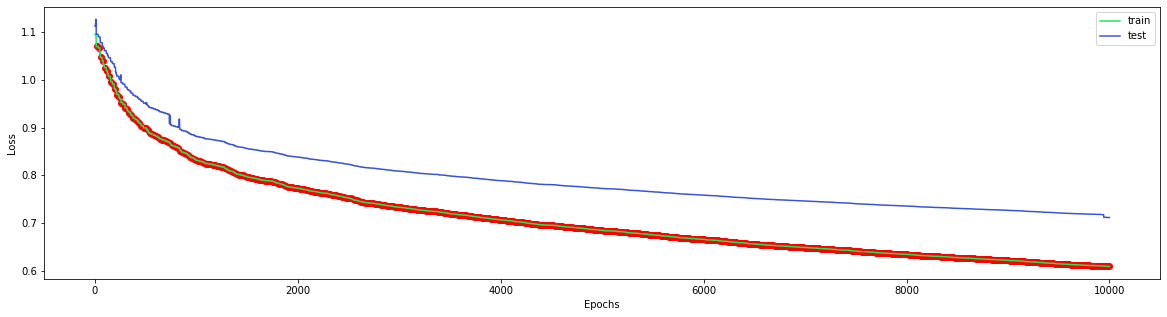

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(loss_history)+1)]
x1 = [20*i for i in range(1, len(loss_history_epochs)+1)]
fig = plt.figure(figsize=(20,5))

plt.plot(x1, loss_history_epochs, color = '#ff0000', marker='o')
plt.plot(x, loss_history, label = "train", color= '#20e658')
plt.plot(x, val_loss_history, label = 'test', color = '#3954db')


# plt.ylim(ymin=0.4,ymax=1.35)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"loss.png")

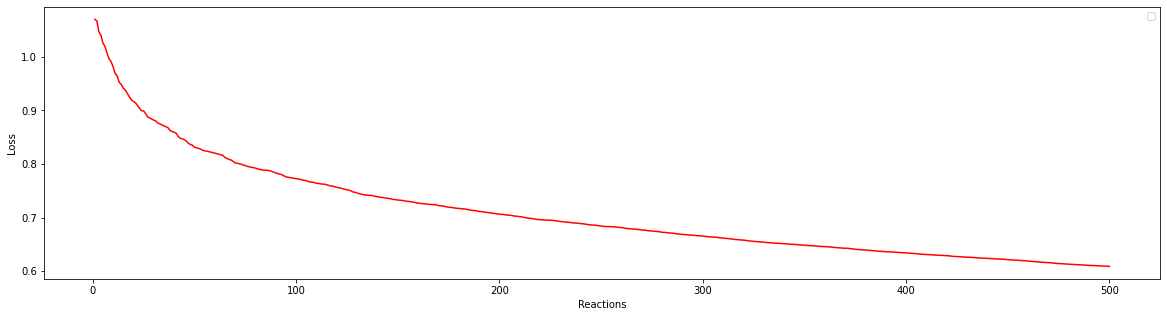

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# x = [i for i in range(1, len(loss_history)+1)]
x1 = [i for i in range(1, len(loss_history_epochs)+1)]
fig = plt.figure(figsize=(20,5))

plt.plot(x1, loss_history_epochs, color = '#ff0000')
# plt.plot(x, loss_history, label = "train", color= '#a89deb')
# plt.plot(x, val_loss_history, label = 'test', color = '#9debb3')
# plt.ylim(ymin=0.4,ymax=1.35)
plt.xlabel("Reactions")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"loss.png")

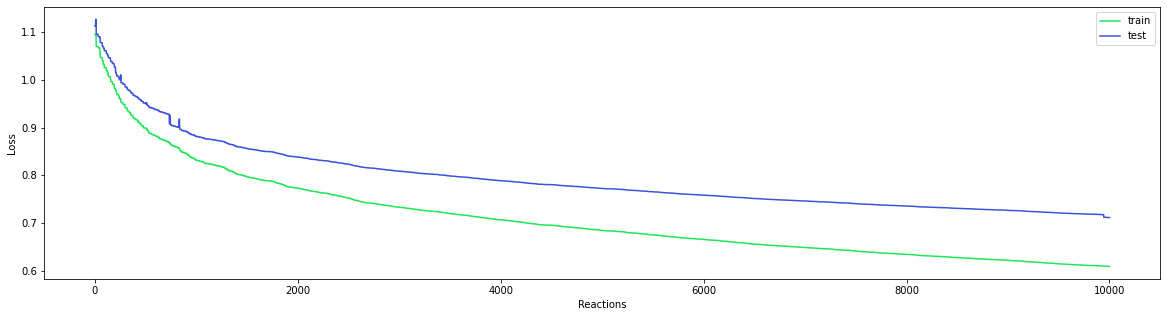

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(loss_history)+1)]
# x1 = [50*i for i in range(1, len(loss_history_epochs)+1)]
fig = plt.figure(figsize=(20,5))

# plt.plot(x1, loss_history_epochs, color = '#ff0000', marker='o')
plt.plot(x, loss_history, label = "train", color= '#20e658')
plt.plot(x, val_loss_history, label = 'test', color = '#3954db')
# plt.ylim(ymin=0.4,ymax=1.35)
plt.xlabel("Reactions")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"loss.png")

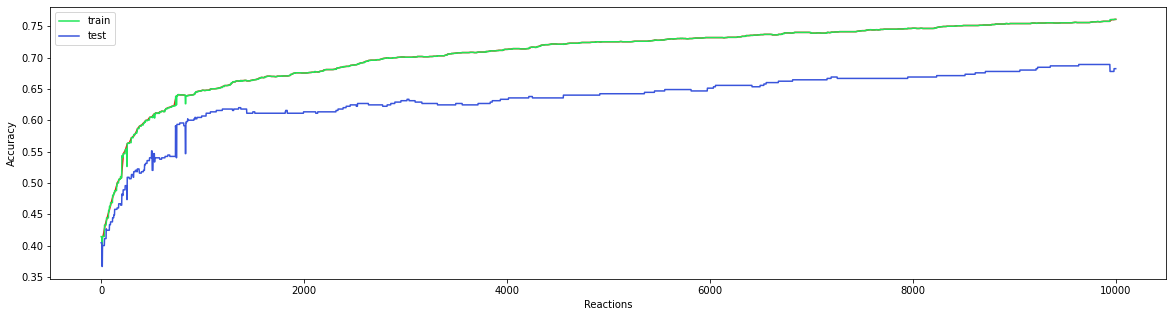

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(acc_history)+1)]
x1 = [20*i for i in range(1, len(acc_history_epochs)+1)]

fig = plt.figure(figsize=(20,5))

plt.plot(x1, acc_history_epochs, color = '#ff0000')
plt.plot(x, acc_history, label = "train", color= '#20e658')
plt.plot(x, val_acc_history, label = 'test', color = '#3954db')
# plt.ylim(ymin=0.2,ymax=0.85)
plt.xlabel("Reactions")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"accuracy.png")

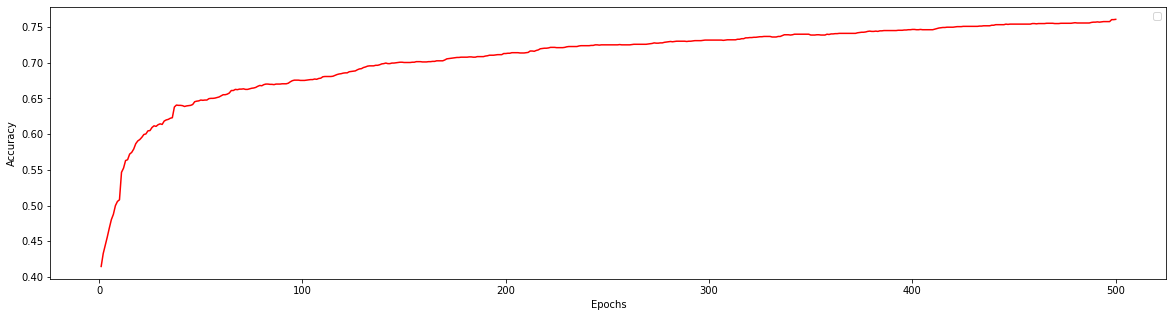

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# x = [i for i in range(1, len(acc_history)+1)]
x1 = [i for i in range(1, len(acc_history_epochs)+1)]

fig = plt.figure(figsize=(20,5))

plt.plot(x1, acc_history_epochs, color = '#ff0000')
# plt.plot(x, acc_history, label = "train", color= '#a89deb')
# plt.plot(x, val_acc_history, label = 'test', color = '#9debb3')
# plt.ylim(ymin=0.2,ymax=0.85)
# plt.xlim(xmin=0,xmax=500)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"accuracy.png")

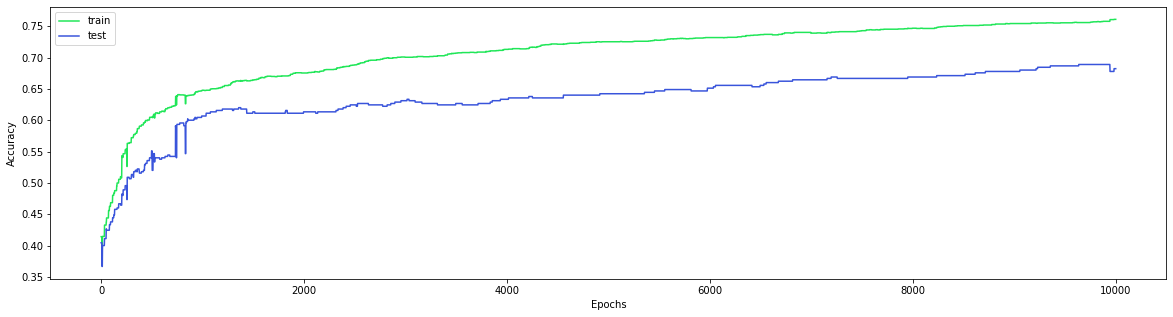

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(1, len(acc_history)+1)]
# x1 = [50*i for i in range(1, len(acc_history_epochs)+1)]

fig = plt.figure(figsize=(20,5))

# plt.plot(x1, acc_history_epochs, color = '#ff0000', marker='o')
plt.plot(x, acc_history, label = "train", color= '#20e658')
plt.plot(x, val_acc_history, label = 'test', color = '#3954db')
# plt.ylim(ymin=0.2,ymax=0.85)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig(BASE_PATH+"accuracy.png")

In [ ]:
best_acc_mole = molecule[0]
best_loss_mole = molecule[0]
for m in molecule:
    print(m.PE.numpy(), m.acc, m.val_loss.numpy(), m.val_acc)
    if m.PE < best_loss_mole.PE:
        best_loss_mole = m
    if m.acc > best_acc_mole.acc:
        best_acc_mole = m

0.6260998 0.7357675696898311 0.72964805 0.6844444444444444
0.6257906 0.7467608951707891 0.7399158 0.6644444444444444
0.60874766 0.7608951707891637 0.71132517 0.6822222222222222
0.6294661 0.7381232822928936 0.73471624 0.6755555555555556
0.62922215 0.7495092265410287 0.7376714 0.6533333333333333
0.6373276 0.7491166077738516 0.7476502 0.66
0.62123 0.7467608951707891 0.72690874 0.6822222222222222
0.6280324 0.7408716136631331 0.73101705 0.6733333333333333
0.6170755 0.7522575579112681 0.72871983 0.68
0.61767757 0.7546132705143306 0.73584 0.6688888888888889
0.625143 0.7487239890066745 0.73526883 0.6777777777777778
0.6348214 0.7369454259913624 0.7476414 0.6444444444444445
0.6273599 0.7447978013349038 0.74901056 0.66
0.6369593 0.7451904201020809 0.73430854 0.6733333333333333
0.6089946 0.7581468394189242 0.71695256 0.6888888888888889
0.6112247 0.7612877895563408 0.72376287 0.6866666666666666
0.6249304 0.7491166077738516 0.7375715 0.6622222222222223
0.62110656 0.7553985080486847 0.72989005 0.6688

In [ ]:
best_acc_mole.PE.numpy(), best_acc_mole.acc

(0.6112247, 0.7612877895563408)

In [ ]:
best_loss_mole.PE.numpy(), best_loss_mole.acc

(0.60874766, 0.7608951707891637)

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import tensorflow_addons as tfa

In [ ]:
def best_loss_molecule():
    bm = molecule[0]
    for m in molecule:
        if m.PE < bm.PE:
            bm = m
    return bm


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [ ]:
import tensorflow_addons as tfa

train_y_one_hot = np.zeros((train_y.size, 3))
train_y_one_hot[np.arange(train_y.size),train_y] = 1

test_y_one_hot = np.zeros((test_y.size, 3))
test_y_one_hot[np.arange(test_y.size),test_y] = 1

In [ ]:
#Training Data
def train_metrics_calculator(final_molecule):
    f1_metric = tfa.metrics.F1Score(num_classes=3)
    ck_metric = tfa.metrics.CohenKappa(num_classes=3, sparse_labels=True)
    finetune_model.set_weights(weights=final_molecule.weights)
    logits = finetune_model(train_x)
    f1_metric.update_state(train_y_one_hot, logits)
    f1_result = f1_metric.result()

    ck_metric.update_state(train_y , np.argmax(logits, axis = 1))
    ck_result = ck_metric.result()

    print(f1_result.numpy())
    print(ck_result.numpy())

In [ ]:
def test_metrics_calculator(final_molecule):
    f1_metric_test = tfa.metrics.F1Score(num_classes=3)
    ck_metric_test = tfa.metrics.CohenKappa(num_classes=3, sparse_labels=True)

    finetune_model.set_weights(weights=final_molecule.weights)
    logits_test = finetune_model(test_x)
    f1_metric_test.update_state(test_y_one_hot, logits_test)
    f1_result_test = f1_metric_test.result()

    ck_metric_test.update_state(test_y , np.argmax(logits_test, axis = 1))
    ck_result_test = ck_metric_test.result()

    print(f1_result_test.numpy())
    print(ck_result_test.numpy())

In [ ]:
m = best_loss_molecule()
train_metrics_calculator(m)

[0.8180282  0.70638824 0.7534003 ]
0.64127153


In [ ]:
test_metrics_calculator(m)

[0.7409836 0.6006826 0.7019868]
0.5239222


[[726  71  58]
 [121 575 146]
 [ 73 140 637]]


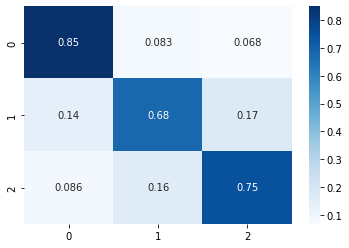

In [ ]:
finetune_model.set_weights(weights=m.weights)
logits = finetune_model(train_x)
y_pred = np.argmax(logits, axis = 1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(train_y, y_pred))

import seaborn as sns
sns.heatmap(confusion_matrix(train_y, y_pred, normalize='true'), cmap='Blues',annot=True)

[[113  20  11]
 [ 33  88  36]
 [ 15  28 106]]


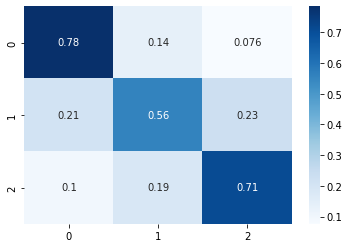

In [ ]:
finetune_model.set_weights(weights=m.weights)
logits = finetune_model(test_x)
y_pred = np.argmax(logits, axis = 1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(test_y, y_pred))

import seaborn as sns
sns.heatmap(confusion_matrix(test_y, y_pred, normalize='true'), cmap='Blues',annot=True)

In [ ]:
def metrics_calculator(final_molecule):
    train_y_one_hot = np.zeros((data_y_model2.size, 3))
    train_y_one_hot[np.arange(data_y_model2.size),data_y_model2] = 1

    f1_metric = tfa.metrics.F1Score(num_classes=3)
    ck_metric = tfa.metrics.CohenKappa(num_classes=3, sparse_labels=True)
    finetune_model.set_weights(weights=final_molecule.weights)
    logits = finetune_model(data_x_model2)
    f1_metric.update_state(train_y_one_hot, logits)
    f1_result = f1_metric.result()

    ck_metric.update_state(data_y_model2 , np.argmax(logits, axis = 1))
    ck_result = ck_metric.result()

    print(f1_result.numpy())
    print(ck_result.numpy())

In [ ]:
metrics_calculator(m)

[0.68720376 0.7487296  0.5638149 ]
0.5004997


[[290  45  35]
 [154 663 182]
 [ 30  64 201]]
0.5004997121799105


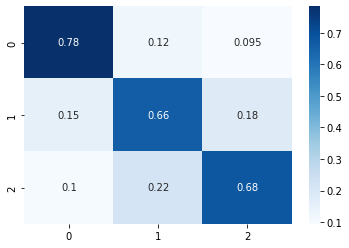

In [ ]:
finetune_model.set_weights(weights=m.weights)
logits = finetune_model(data_x_model2)
y_pred = np.argmax(logits, axis = 1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(data_y_model2, y_pred))
print(cohen_kappa_score(data_y_model2, y_pred))

import seaborn as sns
sns.heatmap(confusion_matrix(data_y_model2, y_pred, normalize='true'), cmap='Blues',annot=True)

In [ ]:
save_molecules(molecule, "model2_cro_molecule_weights_20_500")

In [ ]:
histories = BASE_PATH + "model2_history_20_500"
with open(histories, 'wb') as f:
    pickle.dump(loss_history, f)
    pickle.dump(loss_history_epochs, f)
    pickle.dump(acc_history, f)
    pickle.dump(acc_history_epochs, f)
    pickle.dump(val_loss_history, f)
    pickle.dump(val_loss_history_epochs, f)
    pickle.dump(val_acc_history, f)
    pickle.dump(val_acc_history_epochs, f)